In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import LearningRateScheduler
import math
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import rasterio
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns

# Useful functions

In [45]:
def inverse_scaling(scaled_data, original_min, original_max):
    return scaled_data * (original_max - original_min) + original_min

In [46]:
def plot_diag(x,y,name):
    plt.figure(figsize=(14,7))
    plt.bar(x, y)
    plt.xlabel('Date')
    plt.ylabel(f'{name}')
    plt.title(f'{name} over Time')
    plt.show()

In [47]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over time")
    plt.legend()
    plt.show()

In [48]:
def standardise_data(data, dtype='train', scaler=None):
    if dtype == 'train':
        # Create a scaler object
        scaler = StandardScaler()
        # Fit and transform the data
        data = np.array(data)
        data_norm = scaler.fit_transform(data)
    elif dtype == 'test':
        # Only transform the data
        data_norm = scaler.transform(data)
    
    return data_norm, scaler

In [49]:
def minmax_data(data, dtype='train', scaler=None):
    if dtype == 'train':
        # Create a scaler object
        scaler = MinMaxScaler()
        # Fit and transform the data
        data = np.array(data)
        data_norm = scaler.fit_transform(data)
    elif dtype == 'test':
        data_norm = scaler.transform(data)
    
    return data_norm, scaler

In [50]:
def rebuild_data(df, var, ts=30):
    input_values = []
    target_values = []

    for location in df['loc'].unique():
        loc_df = df[df['loc'] == location]  # select the current location only
        loc_df['date'] = pd.to_datetime(loc_df['date'])
        loc_df = loc_df.sort_values('date')  # sort the data
        loc_df.reset_index(drop=True, inplace=True)  # reset the index

        # find the time gap
        time_gaps = loc_df['date'].diff() > pd.Timedelta(1, 'D')
        time_gaps = time_gaps[time_gaps].index.tolist()

        start = 0
        if time_gaps != []:
            for end in time_gaps:
                # Subtract ts from end so that i+ts will not go out of bounds
                for i in range(start, end - ts):
                    input_values.append(loc_df[var][i:i+ts])
                    target_values.append(loc_df['station_SWE'][i+ts])
                start = end + 1

        # last continuous time series
        if len(loc_df) - start >= ts:  # Add this line
            for i in range(start, len(loc_df) - ts):
                input_values.append(loc_df[var][i:i+ts])
                target_values.append(loc_df['station_SWE'][i+ts])

    input_values = np.array(input_values)
    target_values = np.array(target_values)
    
    return input_values, target_values


In [51]:
def split_dataset(X, Y, test_size=0.2,random_state=42):
    # Split into train and test sets
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val

In [96]:
def get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, feature_idx, batch_size=32, ts=90):
    # Convert data to torch tensors
    X_train = torch.tensor(X_train_90[:,:,0:feature_idx+1].reshape(-1,ts,feature_idx+1)).float()
    X_val = torch.tensor(X_val_90[:,:,0:feature_idx+1].reshape(-1,ts,feature_idx+1)).float()
    X_test = torch.tensor(X_test_90[:,:,0:feature_idx+1].reshape(-1,ts,feature_idx+1)).float()
    y_train = torch.tensor(y_train_90.reshape(-1,1)).float()
    y_val = torch.tensor(y_val_90.reshape(-1,1)).float()
    y_test = torch.tensor(y_test_90.reshape(-1,1)).float()

    # Create data loaders
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
    val_data = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [54]:
def kge(real, pred):
    # reshape the input into one dim
    r = np.corrcoef(pred, real)[0,1]
    alpha = np.std(pred) / np.std(real)
    beta = np.mean(pred) / np.mean(real)
    kge = 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)
    return kge

In [91]:
def evaluate_model(test_loader, model, y_scaler):
    # evaluation mode
    model.eval()

    test_predictions = []
    y_test_real = []

    # predict on the test data
    with torch.no_grad():
        for i, (X, Y) in enumerate(test_loader):
            X = X.float()
            Y = Y.float()
            outputs = model(X)
            test_predictions.append(outputs.numpy())
            y_test_real.append(Y.numpy())

    # concatenate the list of numpy arrays into one numpy array
    test_predictions = np.concatenate(test_predictions).reshape(-1, 1)
    y_test_real = np.concatenate(y_test_real).reshape(-1, 1)

    # reverse the scaling
    test_pred = y_scaler.inverse_transform(test_predictions)
    y_test_ori = y_scaler.inverse_transform(y_test_real)
    
    # Calculate the mean squared error
    mse_test = mean_squared_error(y_test_ori, test_pred)
    kge_test = kge(y_test_ori.reshape(-1), test_pred.reshape(-1))

    print('Mean Squared Error on Test Data:', mse_test)
    print('Kling-Gupta efficiency on Test Data:', kge_test)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_ori, test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of True vs Predicted Values')
    plt.plot([min(y_test_ori), max(y_test_ori)], [min(y_test_ori), max(y_test_ori)], color='red')  # plot y_true=y_pred
    plt.show()

# Read data

In [56]:
folder_path = '/Users/yz6622/Desktop/IRP/dataset/swiss_station/Preprocessed_data/'

In [57]:
file_path = folder_path + 'train.csv'

# read data
df = pd.read_csv(file_path)

print(df.head())

         date        HS  station_SWE  Sturm_SWE (cm)  deltaSnow_SWE (cm)  \
0  2003-09-30  0.000000     0.000000        0.000000            0.000000   
1  2003-10-01  0.005578     0.368191        0.002497            0.002397   
2  2003-10-02  0.005129     0.351574        0.002309            0.002397   
3  2003-10-03  0.004589     0.395334        0.002077            0.002397   
4  2003-10-04  0.005668     0.395153        0.002585            0.002397   

            loc  precipitation      snowfall  solar_radiation  temperature  \
0  canada_3A25P   3.662044e-08  3.663723e-08         0.032299     0.522216   
1  canada_3A25P   3.662044e-08  3.663723e-08         0.030108     0.555290   
2  canada_3A25P   5.450587e-04  3.663723e-08         0.029086     0.508123   
3  canada_3A25P   1.820036e-05  3.663723e-08         0.028209     0.517716   
4  canada_3A25P   5.452784e-05  3.663723e-08         0.027096     0.476645   

       rain     month  
0  0.062383  0.727273  
1  0.062383  0.818182  
2 

In [58]:
# set the datetime and sort the values
df = df.sort_values(by="date")
df.reset_index(drop=True, inplace=True)

In [59]:
file_path = folder_path + 'test.csv'

# read data
df_test = pd.read_csv(file_path)

print(df_test.head())

         date        HS  station_SWE  Sturm_SWE (cm)  deltaSnow_SWE (cm)  \
0  2008-10-02  0.010750     2.788030        0.004870            0.012337   
1  2008-10-03  0.009824     2.538696        0.004473            0.011273   
2  2008-10-04  0.008898     2.111562        0.004072            0.010210   
3  2008-10-05  0.007971     1.740292        0.003666            0.009147   
4  2008-10-06  0.007045     1.235040        0.003257            0.008084   

            loc  precipitation      snowfall  solar_radiation  temperature  \
0  canada_4B16P   3.662044e-08  3.663723e-08         0.017846     0.512300   
1  canada_4B16P   2.580432e-01  3.663723e-08         0.004604     0.488581   
2  canada_4B16P   1.571692e-01  3.663723e-08         0.005102     0.490934   
3  canada_4B16P   2.680880e-01  2.984925e-02         0.006188     0.418342   
4  canada_4B16P   1.960084e-02  6.193011e-03         0.014789     0.422286   

       rain     month  
0  0.062383  0.818182  
1  0.314164  0.818182  
2 

# Data pre-process - snow class

In [63]:
# inverse all the features
df['HS'] = inverse_scaling(df['HS'], 0.0, 555.7083333333334)
df['precipitation'] = inverse_scaling(df['precipitation'], 0, 0.0508635304868221)
df['snowfall'] = inverse_scaling(df['snowfall'], 0, 0.0508402287960052)
df['solar_radiation'] = inverse_scaling(df['solar_radiation'], 0, 22261948.0)
df['temperature'] = inverse_scaling(df['temperature'], -29.88636779785156, 39.6531982421875)
df['rain'] = inverse_scaling(df['rain'], 0, 0.0488765742629765)
df['month'] = inverse_scaling(df['month'], 1, 12)

In [64]:
# inverse all the features
df_test['HS'] = inverse_scaling(df_test['HS'], 0.0, 555.7083333333334)
df_test['precipitation'] = inverse_scaling(df_test['precipitation'], 0, 0.0508635304868221)
df_test['snowfall'] = inverse_scaling(df_test['snowfall'], 0, 0.0508402287960052)
df_test['solar_radiation'] = inverse_scaling(df_test['solar_radiation'], 0, 22261948.0)
df_test['temperature'] = inverse_scaling(df_test['temperature'], -29.88636779785156, 39.6531982421875)
df_test['rain'] = inverse_scaling(df_test['rain'], 0, 0.0488765742629765)
df_test['month'] = inverse_scaling(df_test['month'], 1, 12)

In [177]:
# # add 'sin_month'
# df_test['month_ori'] = df_test['month'] * (12 - 1) + 1
# df['month_ori'] = df['month'] * (12 - 1) + 1

In [178]:
# df_test['month_sin'] = np.sin(2 * np.pi * df_test['month_ori']/12.0)
# df_test['month_cos'] = np.cos(2 * np.pi * df_test['month_ori']/12.0)
# df['month_sin'] = np.sin(2 * np.pi * df['month_ori']/12.0)
# df['month_cos'] = np.cos(2 * np.pi * df['month_ori']/12.0)

In [284]:
# drop the duplicated data
# df = df.drop(df[(df['loc'] == 'wfj')|(df['loc'] == 'gps1')].index)

## add snow class

In [65]:
location = df['loc'].unique()

In [66]:
lonlat = {}

In [67]:
lonlat['canada_3A25P'] = [50.1543, -123.4361]
lonlat['canada_3A20P'] = [50.13706, -123.10289]
lonlat['canada_4A30P'] = [56.43686, -125.7417]
lonlat['canada_4B16P'] = [55.86165, -127.69842]
lonlat['norway_121420'] = [60.681, 8.004]
lonlat['norway_62420'] = [60.866, 6.473]
lonlat['norway_850'] = [59.968, 10.547]
lonlat['norway_77240'] = [61.366, 6.906]
lonlat['norway_211270'] = [59.619, 7.427]
lonlat['gps2'] = [46.8297, 9.8094]
lonlat['gps1'] = [46.8297, 9.8094]
lonlat['wfj'] = [46.8297, 9.8094]
lonlat['klo'] = [46.8636, 9.8881]

In [68]:
snow_class = {}
for _, key in enumerate(lonlat):
    lon = lonlat[f'{key}'][1]
    lat = lonlat[f'{key}'][0]

    # open the class scheme file
    with rasterio.open('/Users/yz6622/Desktop/IRP/dataset/SnowClass_GL_50km_0.50degree_2021_v01.0.tif') as src:
        # change the lat and lon into the pixel and pixel
        py, px = src.index(lon, lat)
        # get the corresponding values
        snow_class_value = src.read(1)[py, px]

    print(f'The snow classification at {key} is:', snow_class_value)
    snow_class[f'{key}'] = snow_class_value

The snow classification at canada_3A25P is: 3
The snow classification at canada_3A20P is: 3
The snow classification at canada_4A30P is: 2
The snow classification at canada_4B16P is: 6
The snow classification at norway_121420 is: 1
The snow classification at norway_62420 is: 3
The snow classification at norway_850 is: 6
The snow classification at norway_77240 is: 3
The snow classification at norway_211270 is: 1
The snow classification at gps2 is: 1
The snow classification at gps1 is: 1
The snow classification at wfj is: 1
The snow classification at klo is: 1


In [69]:
df['snow_class'] = df['loc'].map(snow_class)
df_test['snow_class'] = df_test['loc'].map(snow_class)

In [70]:
df_1 = df[df['snow_class'] == 1]
df_test_1 = df_test[df_test['snow_class'] == 1]

In [71]:
df_3 = df[df['snow_class'] == 3]
df_test_3 = df_test[df_test['snow_class'] == 3]

In [72]:
df_6 = df[df['snow_class'] == 6]
df_test_6 = df_test[df_test['snow_class'] == 6]

In [221]:
df1 = df[df['snow_class'] == 1]
dftest1 = df_test[df_test['snow_class'] == 1]

In [74]:
df_1.describe()

,HS,station_SWE,Sturm_SWE (cm),deltaSnow_SWE (cm),precipitation,snowfall,solar_radiation,temperature,rain,month,snow_class
count,6820.000000,6820.000000,6820.000000,6820.000000,6.820000e+03,6.820000e+03,6.820000e+03,6820.000000,6820.000000,6820.000000,6820.0
mean,63.139732,20.812707,0.094752,0.114846,1.743342e-03,1.068667e-03,3.744744e+06,0.584998,0.003682,6.472287,1.0
std,73.348655,26.565438,0.117023,0.143039,3.141835e-03,2.395504e-03,3.526881e+06,8.698330,0.001954,3.549449,0.0
min,0.000000,0.000000,0.000000,0.000000,1.862645e-09,9.313225e-10,2.468300e+04,-26.480560,0.001990,1.000000,1.0
25%,0.671870,0.000000,0.000836,0.000773,2.943957e-05,1.862645e-09,7.092518e+05,-5.847412,0.003050,3.000000,1.0
50%,35.000000,9.894949,0.043239,0.046980,4.670326e-04,4.429929e-05,2.564423e+06,0.343246,0.003054,6.000000,1.0
75%,103.352600,32.517194,0.153071,0.185874,2.037137e-03,9.395200e-04,6.094414e+06,7.134117,0.003356,10.000000,1.0
max,307.100000,125.043245,0.520901,0.576600,4.430208e-02,2.846091e-02,1.482759e+07,21.561829,0.041247,12.000000,1.0


## scale

In [76]:
scaler_y_dict={}

In [31]:
# for s_cls, sub_df, sub_df_test in zip([1,3,6], [df_1,df_3,df_6], [df_test_1,df_test_3,df_test_6]):
#     # Standardize specific columns
#     sub_df['temperature'], scaler_temp = standardise_data(np.array(sub_df['temperature']).reshape(-1,1), 'train')
#     sub_df[['HS','precipitation','snowfall','solar_radiation','rain','month']], scaler_minmax = minmax_data(sub_df[['HS','precipitation','snowfall','solar_radiation','rain','month']], 'train')
#     sub_df['station_SWE'], scaler_y = minmax_data(np.array(sub_df['station_SWE']).reshape(-1,1), 'train')
#     # Save the scaler to dictionary
#     scaler_y_dict[s_cls] = scaler_y
    
#     # Apply the same scaling to test set
#     sub_df_test['temperature'], _ = standardise_data(np.array(sub_df_test['temperature']).reshape(-1,1), 'test', scaler_temp)
#     sub_df_test[['HS','precipitation','snowfall','solar_radiation','rain','month']], _ = minmax_data(sub_df_test[['HS','precipitation','snowfall','solar_radiation','rain','month']], 'test', scaler_minmax)
#     sub_df_test['station_SWE'], _ = minmax_data(np.array(sub_df_test['station_SWE']).reshape(-1,1), 'test', scaler_y)

In [270]:
df_1.describe()

,HS,station_SWE,Sturm_SWE (cm),deltaSnow_SWE (cm),precipitation,snowfall,solar_radiation,temperature,rain,month,snow_class
count,5187.000000,5187.000000,5187.000000,5187.000000,5.187000e+03,5.187000e+03,5187.000000,5187.000000,5187.000000,5187.000000,5187.0
mean,0.090550,15.237190,0.073971,0.089529,3.432583e-02,2.115983e-02,0.145375,0.428190,0.075239,0.500622,1.0
std,0.109791,20.545929,0.094908,0.116554,5.972527e-02,4.562990e-02,0.154410,0.127212,0.039364,0.321098,0.0
min,0.000000,0.000000,0.000000,0.000000,3.662044e-08,1.831861e-08,0.001109,0.048977,0.040720,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,8.933008e-04,3.663723e-08,0.016591,0.333814,0.062408,0.181818,1.0
50%,0.040489,5.091385,0.025977,0.030356,1.054288e-02,1.416688e-03,0.089662,0.422630,0.062469,0.454545,1.0
75%,0.159256,24.864113,0.126438,0.151463,4.096245e-02,2.007560e-02,0.233958,0.526929,0.068609,0.818182,1.0
max,0.523656,107.609076,0.482903,0.566435,8.709990e-01,4.718855e-01,0.666051,0.739841,0.843910,1.000000,1.0


In [271]:
df1.describe()

,HS,station_SWE,Sturm_SWE (cm),deltaSnow_SWE (cm),precipitation,snowfall,solar_radiation,temperature,rain,month,snow_class
count,5187.000000,5187.000000,5187.000000,5187.000000,5.187000e+03,5.187000e+03,5.187000e+03,5187.000000,5187.000000,5187.000000,5187.0
mean,50.319640,15.237190,0.073971,0.089529,1.745933e-03,1.075770e-03,3.236335e+06,-0.110203,0.003677,6.506844,1.0
std,61.012014,20.545929,0.094908,0.116554,3.037838e-03,2.319834e-03,3.437473e+06,8.846298,0.001924,3.532083,0.0
min,0.000000,0.000000,0.000000,0.000000,1.862645e-09,9.313225e-10,2.468300e+04,-26.480560,0.001990,1.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,4.543643e-05,1.862645e-09,3.693580e+05,-6.673096,0.003050,3.000000,1.0
50%,22.500000,5.091385,0.025977,0.030356,5.362481e-04,7.202476e-05,1.996054e+06,-0.496887,0.003053,6.000000,1.0
75%,88.500000,24.864113,0.126438,0.151463,2.083495e-03,1.020648e-03,5.208372e+06,6.756042,0.003353,10.000000,1.0
max,291.000000,107.609076,0.482903,0.566435,4.430208e-02,2.399077e-02,1.482759e+07,21.561829,0.041247,12.000000,1.0


In [77]:
df_1['temperature'], scaler_temp = standardise_data(np.array(df_1['temperature']).reshape(-1,1), 'train')
df_1[['HS','precipitation','snowfall','solar_radiation','rain','month']], scaler_minmax = minmax_data(df_1[['HS','precipitation','snowfall','solar_radiation','rain','month']], 'train')
df_1['station_SWE'], scaler_y = minmax_data(np.array(df_1['station_SWE']).reshape(-1,1), 'train')

# Apply the same scaling to test set
df_test_1['temperature'], _ = standardise_data(np.array(df_test_1['temperature']).reshape(-1,1), 'test', scaler_temp)
df_test_1[['HS','precipitation','snowfall','solar_radiation','rain','month']], _ = minmax_data(df_test_1[['HS','precipitation','snowfall','solar_radiation','rain','month']], 'test', scaler_minmax)
df_test_1['station_SWE'], _ = minmax_data(np.array(df_test_1['station_SWE']).reshape(-1,1), 'test', scaler_y)

In [79]:
scaler_minmax.inverse_transform(df_1[['HS','precipitation','snowfall','solar_radiation','rain','month']]).max()

14827594.333948927

In [80]:
scaler_y.inverse_transform(np.array(df_test_1['station_SWE']).reshape(-1,1)).max()

72.1158233898859

In [136]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_1['loc_encoded'] = encoder.fit_transform(df_1['loc'])


In [150]:
df_test_1['loc_encoded'] = encoder.transform(df_test_1['loc'])

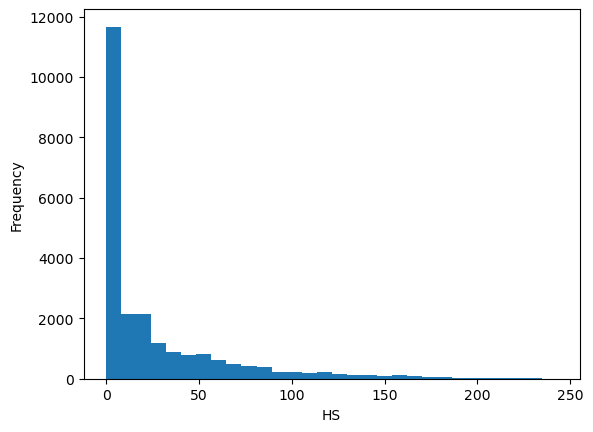

In [127]:
import matplotlib.pyplot as plt

plt.hist(df['station_SWE'], bins=30)
plt.xlabel('HS')
plt.ylabel('Frequency')
plt.show()

In [128]:
import numpy as np

# Add a small constant to all values in the data
df_3['HS'] = df_3['HS'] + 1e-9

# Apply log transformation
df_3['HS'] = np.log(df_3['HS'])

# Models

In [83]:
class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dims=[70, 50, 20], num_epochs=60, output_dim=1):
        super(LSTM, self).__init__()
        self.hidden_dims = hidden_dims
        self.lstm1 = nn.LSTM(input_dim, hidden_dims[0], num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dims[0], hidden_dims[1], num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dims[1], hidden_dims[2], num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dims[-1], output_dim)
        self.num_epochs = num_epochs

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out, _ = self.lstm3(lstm_out)
        out = self.fc(lstm_out[:, -1, :])
        return out

    def train_model(self, ts, n_features, train_loader, val_loader, optimizer, criterion, scheduler):
        train_losses = []
        val_losses = []
        for epoch in range(self.num_epochs):
            # Training
            self.train()  # Set the model to training mode
            running_train_loss = 0.0
            for i, (X, Y) in enumerate(train_loader):
                X = X.float()
                Y = Y.float()
                optimizer.zero_grad()
                outputs = self(X.reshape(-1, ts, n_features)) 
                loss = criterion(outputs, Y)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * X.size(0)
            avg_train_loss = running_train_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)

            # Validation
            self.eval()  # Set the model to evaluation mode
            running_val_loss = 0.0
            with torch.no_grad():
                for i, (X, Y) in enumerate(val_loader):
                    X = X.float()
                    Y = Y.float()
                    outputs = self(X.reshape(-1, ts, n_features))
                    loss = criterion(outputs, Y)
                    running_val_loss += loss.item() * X.size(0)
            avg_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

            # Decay Learning Rate
            scheduler.step()

        return train_losses, val_losses

snow_3

In [294]:
# class LSTM(nn.Module):
#     def __init__(self, input_dim=1, hidden_dims=[70, 50, 20], num_epochs=60, output_dim=1):
#         super(LSTM, self).__init__()
#         self.hidden_dims = hidden_dims
#         self.lstm1 = nn.LSTM(input_dim, hidden_dims[0], num_layers=1, batch_first=True)
#         self.lstm2 = nn.LSTM(hidden_dims[0], hidden_dims[1], num_layers=1, batch_first=True)
#         self.lstm3 = nn.LSTM(hidden_dims[1], hidden_dims[2], num_layers=1, batch_first=True)
#         self.fc = nn.Linear(hidden_dims[-1], output_dim)
#         self.num_epochs = num_epochs

#     def forward(self, x):
#         lstm_out, _ = self.lstm1(x)
#         lstm_out, _ = self.lstm2(lstm_out)
#         lstm_out, _ = self.lstm3(lstm_out)
#         out = self.fc(lstm_out[:, -1, :])
#         return out

#     def train_model(self, ts, n_features, train_loader, val_loader, optimizer, criterion, scheduler):
#         train_losses = []
#         val_losses = []
#         for epoch in range(self.num_epochs):
#             # Training
#             self.train()  # Set the model to training mode
#             running_train_loss = 0.0
#             for i, (X, Y) in enumerate(train_loader):
#                 X = X.float()
#                 Y = Y.float()
#                 optimizer.zero_grad()
#                 outputs = self(X.reshape(-1, ts, n_features)) 
#                 loss = criterion(outputs, Y)
#                 loss.backward()
#                 optimizer.step()
#                 running_train_loss += loss.item() * X.size(0)
#             avg_train_loss = running_train_loss / len(train_loader.dataset)
#             train_losses.append(avg_train_loss)

#             # Validation
#             self.eval()  # Set the model to evaluation mode
#             running_val_loss = 0.0
#             with torch.no_grad():
#                 for i, (X, Y) in enumerate(val_loader):
#                     X = X.float()
#                     Y = Y.float()
#                     outputs = self(X.reshape(-1, ts, n_features))
#                     loss = criterion(outputs, Y)
#                     running_val_loss += loss.item() * X.size(0)
#             avg_val_loss = running_val_loss / len(val_loader.dataset)
#             val_losses.append(avg_val_loss)

#             print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

#             # Decay Learning Rate
#             scheduler.step()

#         return train_losses, val_losses

snow_6:

In [295]:
# class LSTM(nn.Module):
#     def __init__(self, input_dim=1, hidden_dims=[70, 50, 50], num_epochs=60, output_dim=1):
#         super(LSTM, self).__init__()
#         self.hidden_dims = hidden_dims
#         self.lstm1 = nn.LSTM(input_dim, hidden_dims[0], num_layers=1, batch_first=True)
#         self.lstm2 = nn.LSTM(hidden_dims[0], hidden_dims[1], num_layers=1, batch_first=True)
#         self.lstm3 = nn.LSTM(hidden_dims[1], hidden_dims[2], num_layers=1, batch_first=True)
#         self.fc = nn.Linear(hidden_dims[-1], output_dim)
#         self.num_epochs = num_epochs

#     def forward(self, x):
#         lstm_out, _ = self.lstm1(x)
#         lstm_out, _ = self.lstm2(lstm_out)
#         lstm_out, _ = self.lstm3(lstm_out)
#         out = self.fc(lstm_out[:, -1, :])
#         return out

#     def train_model(self, ts, n_features, train_loader, val_loader, optimizer, criterion, scheduler):
#         train_losses = []
#         val_losses = []
#         for epoch in range(self.num_epochs):
#             # Training
#             self.train()  # Set the model to training mode
#             running_train_loss = 0.0
#             for i, (X, Y) in enumerate(train_loader):
#                 X = X.float()
#                 Y = Y.float()
#                 optimizer.zero_grad()
#                 outputs = self(X.reshape(-1, ts, n_features)) 
#                 loss = criterion(outputs, Y)
#                 loss.backward()
#                 optimizer.step()
#                 running_train_loss += loss.item() * X.size(0)
#             avg_train_loss = running_train_loss / len(train_loader.dataset)
#             train_losses.append(avg_train_loss)

#             # Validation
#             self.eval()  # Set the model to evaluation mode
#             running_val_loss = 0.0
#             with torch.no_grad():
#                 for i, (X, Y) in enumerate(val_loader):
#                     X = X.float()
#                     Y = Y.float()
#                     outputs = self(X.reshape(-1, ts, n_features))
#                     loss = criterion(outputs, Y)
#                     running_val_loss += loss.item() * X.size(0)
#             avg_val_loss = running_val_loss / len(val_loader.dataset)
#             val_losses.append(avg_val_loss)

#             print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

#             # Decay Learning Rate
#             scheduler.step()

#         return train_losses, val_losses

In [86]:
def train(variables, i, hidden_dims=[70,50,30], num_epochs=60, df=df_1, df_test=df_test_1,scaler_y=scaler_y, step_size=10, gamma=0.5):
    
#     if len(hidden_dims) != 3:
#         print('The dimension of hidden layers is not 3.')
#     else:
    # data preprocess
    input_values, target_values = rebuild_data(df, variables, 90)
    X_test_90, y_test_90 = rebuild_data(df_test, variables, 90)
    X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

    # dataloader
    train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, i, batch_size=64)

    # build model
    model = LSTM(input_dim=i+1, hidden_dims=hidden_dims, num_epochs=num_epochs)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)

    # train
    train_losses, val_losses = model.train_model(90, i+1, train_loader, val_loader, optimizer, criterion, scheduler)

    # plot the loss function
    plot_loss(train_losses, val_losses)

    # evaluate
    evaluate_model(test_loader, model, scaler_y)

    return model

In [72]:
# def train_wfj(variables, i, df=df_3, df_test=df_test_3):
#     # data preprocess
#     input_values, target_values = rebuild_data(df, variables, 90)
# #     X_test_90, y_test_90 = rebuild_data(df_test, variables, 90)
#     X_train_90, val_90_X, y_train_90, val_90_y = split_dataset(input_values, target_values, test_size=0.3)
#     X_val_90, X_test_90, y_val_90, y_test_90 = split_dataset(val_90_X, val_90_y, test_size=0.1)
    
#     # scale y
#     y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')
#     y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
#     y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)
#     # dataloader
#     train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, i, batch_size=32)
    
#     # build model
#     model = LSTM(input_dim=i+1, hidden_dim=90, num_epochs=100)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
    
#     # train
#     train_losses, val_losses = model.train_model(90, i+1, train_loader, val_loader, optimizer, criterion, scheduler)
    
#     # plot the loss function
#     plot_loss(train_losses, val_losses)
    
#     # evaluate
#     evaluate_model(test_loader, model, scaler_y)

In [73]:
# df_wfj = df[df['loc'] == 'wfj']
# df_gps1 = df[df['loc'] == 'gps1']

In [74]:
# train_wfj(['HS','snowfall','temperature','solar_radiation','rain','month_sin','precipitation'], 0, df=df_gps1)

In [75]:
# train_wfj(['HS','snowfall','temperature','solar_radiation','rain','month_sin','precipitation'], 0, df=df_wfj)

In [246]:
# def calculate_weights(y):
#     weights = []
#     for i in range(len(y)):
#         if y[i] >= 50:
#             weights.append(1.2)
#         else:
#             weights.append(1.0)
#     return weights

In [247]:
# def weighted_mse_loss(input, target, weight):
#     return torch.sum(weight * (input - target) ** 2)/len(target)

In [248]:
# class LSTM(nn.Module):
#     def __init__(self, input_dim=1, hidden_dims=[70, 45, 20], num_epochs=60, output_dim=1):
#         super(LSTM, self).__init__()
#         self.hidden_dims = hidden_dims
#         self.lstm1 = nn.LSTM(input_dim, hidden_dims[0], num_layers=1, batch_first=True)
#         self.lstm2 = nn.LSTM(hidden_dims[0], hidden_dims[1], num_layers=1, batch_first=True)
#         self.lstm3 = nn.LSTM(hidden_dims[1], hidden_dims[2], num_layers=1, batch_first=True)
#         self.fc = nn.Linear(hidden_dims[-1], output_dim)
# #         self.sig = nn.Sigmoid()  # activation func
#         self.num_epochs = num_epochs

#     def forward(self, x):
#         lstm_out, _ = self.lstm1(x)
#         lstm_out, _ = self.lstm2(lstm_out)
#         lstm_out, _ = self.lstm3(lstm_out)
#         out = self.fc(lstm_out[:, -1, :])
#         out = out
#         return out

#     def train_model(self, ts, n_features, train_loader, val_loader, optimizer, criterion, scheduler, weights):
#         train_losses = []
#         val_losses = []
#         for epoch in range(self.num_epochs):
#             # Training
#             self.train()  # Set the model to training mode
#             running_train_loss = 0.0
#             for i, (X, Y) in enumerate(train_loader):
#                 X = X.float()
#                 Y = Y.float()
#                 optimizer.zero_grad()
#                 outputs = self(X.reshape(-1, ts, n_features)) 
#                 loss = weighted_mse_loss(outputs, Y, weights)
#                 loss.backward()
#                 optimizer.step()
#                 running_train_loss += loss.item() * X.size(0)
#             avg_train_loss = running_train_loss / len(train_loader.dataset)
#             train_losses.append(avg_train_loss)

#             # Validation
#             self.eval()  # Set the model to evaluation mode
#             running_val_loss = 0.0
#             with torch.no_grad():
#                 for i, (X, Y) in enumerate(val_loader):
#                     X = X.float()
#                     Y = Y.float()
#                     outputs = self(X.reshape(-1, ts, n_features))
#                     loss = weighted_mse_loss(outputs, Y, weights)
#                     running_val_loss += loss.item() * X.size(0)
#             avg_val_loss = running_val_loss / len(val_loader.dataset)
#             val_losses.append(avg_val_loss)

#             print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

#             # Decay Learning Rate
#             scheduler.step()

#         return train_losses, val_losses

In [253]:
# def train(variables, i, hidden_dims=50, num_epochs=60, df=df_1, df_test=df_test_1, scaler_y=scaler_y, step_size=5, gamma=0.5):
    
#     # data preprocess
#     input_values, target_values = rebuild_data(df, variables, 90)
#     X_test_90, y_test_90 = rebuild_data(df_test, variables, 90)
#     X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

#     # Before training, define your weights based on the targets
#     weights = calculate_weights(y_train_90)  # You need to define the calculate_weights function

#     # convert weights to torch tensor
#     weights = torch.from_numpy(np.array(weights)).float()

#     # dataloader
#     train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, i, batch_size=64)

#     # build model
#     model = LSTM(input_dim=i+1, hidden_dims=hidden_dims, num_epochs=num_epochs)
#     criterion = nn.L1Loss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=1)
#     scheduler = StepLR(optimizer, step_size=step_size, gamma=0.7)

#     # train
#     train_losses, val_losses = model.train_model(90, i+1, train_loader, val_loader, optimizer, criterion, scheduler, weights)

#     # plot the loss function
#     plot_loss(train_losses, val_losses)

#     # evaluate
#     evaluate_model(test_loader, model, scaler_y)

#     return model

# HS

snow_6

Epoch 1/60, Train Loss: 0.010939588300957388, Val Loss: 0.002758049040359715
Epoch 2/60, Train Loss: 0.0029127023881301284, Val Loss: 0.002871317157657394
Epoch 3/60, Train Loss: 0.002745053835196825, Val Loss: 0.0022528291816637388
Epoch 4/60, Train Loss: 0.002899639598541476, Val Loss: 0.00276509774358034
Epoch 5/60, Train Loss: 0.0027337007265750652, Val Loss: 0.0023683729788073465
Epoch 6/60, Train Loss: 0.0026839511094198863, Val Loss: 0.0022680082563205695
Epoch 7/60, Train Loss: 0.0027234370323158614, Val Loss: 0.002161528589437661
Epoch 8/60, Train Loss: 0.0025026704876483833, Val Loss: 0.00215815666273068
Epoch 9/60, Train Loss: 0.0024606609451753953, Val Loss: 0.0023265361576720865
Epoch 10/60, Train Loss: 0.002466997748984017, Val Loss: 0.0030539851905041875
Epoch 11/60, Train Loss: 0.0023575498769381124, Val Loss: 0.0020693438378871984
Epoch 12/60, Train Loss: 0.0023250639993281697, Val Loss: 0.002565880869883329
Epoch 13/60, Train Loss: 0.002331325835156882, Val Loss: 0.00

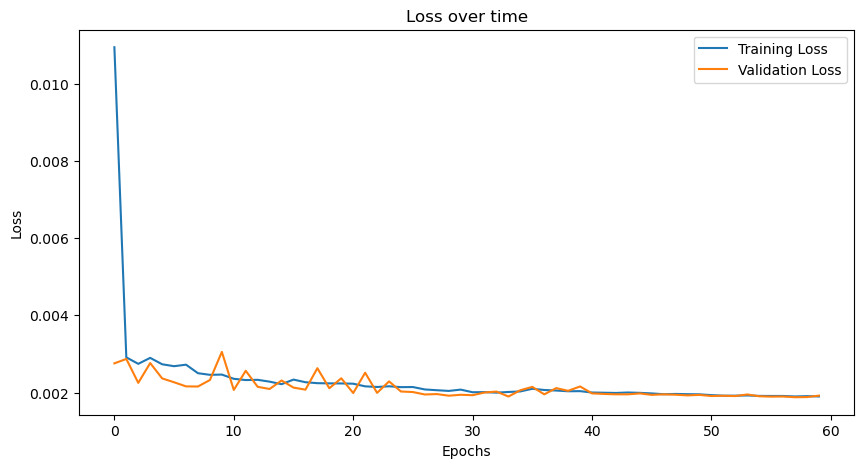

Mean Squared Error on Test Data: 45.891
Kling-Gupta efficiency on Test Data: nan


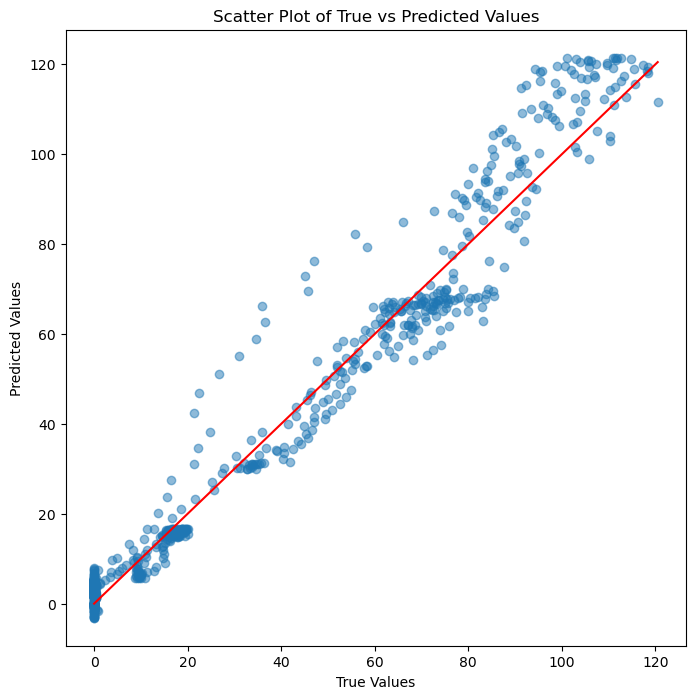

In [60]:
train(['HS'], 0, hidden_dims=[60, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

Epoch 1/60, Train Loss: 0.007966957663327872, Val Loss: 0.0024309810703804944
Epoch 2/60, Train Loss: 0.0031042757626375188, Val Loss: 0.0027490489502113727
Epoch 3/60, Train Loss: 0.0028753773257582725, Val Loss: 0.0023470781442628636
Epoch 4/60, Train Loss: 0.0026486459320499895, Val Loss: 0.002786141465309367
Epoch 5/60, Train Loss: 0.002684915908629839, Val Loss: 0.002296689721911099
Epoch 6/60, Train Loss: 0.002759839841334086, Val Loss: 0.0028983991155798173
Epoch 7/60, Train Loss: 0.0025816982131234606, Val Loss: 0.002302253933756646
Epoch 8/60, Train Loss: 0.0024345811489160864, Val Loss: 0.0022071084750224946
Epoch 9/60, Train Loss: 0.002423323565273729, Val Loss: 0.0024161080424025317
Epoch 10/60, Train Loss: 0.0026918584539308453, Val Loss: 0.002206118523530017
Epoch 11/60, Train Loss: 0.0023201389005699825, Val Loss: 0.002158550357877264
Epoch 12/60, Train Loss: 0.0022657396347195357, Val Loss: 0.0022527363375962773
Epoch 13/60, Train Loss: 0.002285259430661302, Val Loss: 0

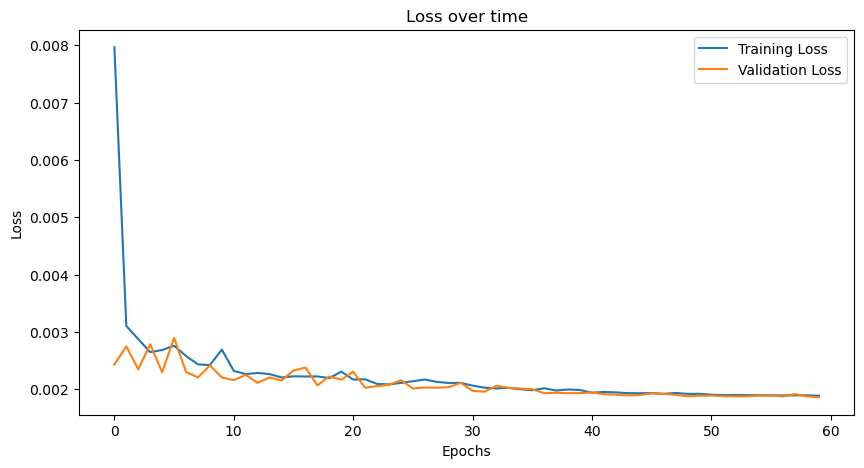

Mean Squared Error on Test Data: 43.39026
Kling-Gupta efficiency on Test Data: nan


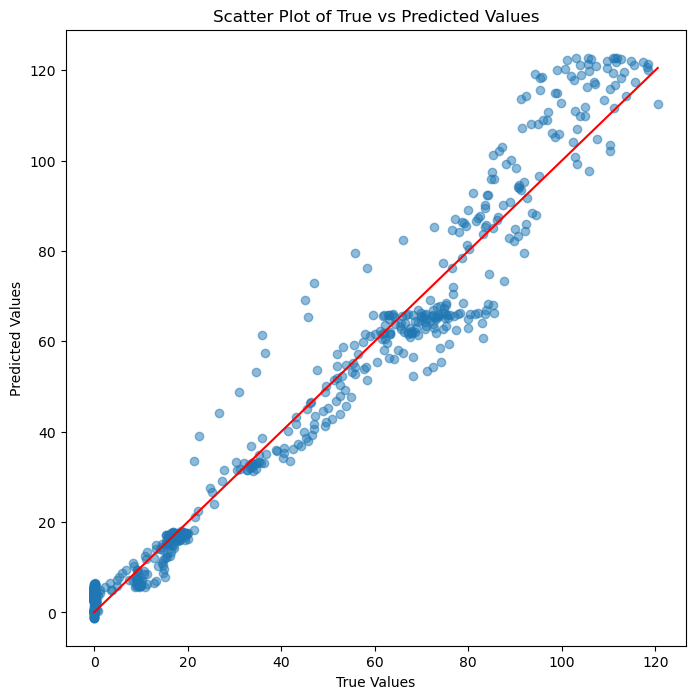

In [77]:
train(['HS'], 0, hidden_dims=[70, 50, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_3

Epoch 1/80, Train Loss: 0.014462932492918286, Val Loss: 0.00662281749349448
Epoch 2/80, Train Loss: 0.007907773116250207, Val Loss: 0.006042320425471952
Epoch 3/80, Train Loss: 0.007959808306948937, Val Loss: 0.007768371611112548
Epoch 4/80, Train Loss: 0.007889200891559768, Val Loss: 0.00639951100813285
Epoch 5/80, Train Loss: 0.0077741824848166965, Val Loss: 0.006993627761520686
Epoch 6/80, Train Loss: 0.00750687446079162, Val Loss: 0.006601438409979305
Epoch 7/80, Train Loss: 0.007420072607136812, Val Loss: 0.006022798005611666
Epoch 8/80, Train Loss: 0.007363745369937172, Val Loss: 0.00581113183570485
Epoch 9/80, Train Loss: 0.007274316940261194, Val Loss: 0.006356789736497787
Epoch 10/80, Train Loss: 0.007276524553230277, Val Loss: 0.005728639584154852
Epoch 11/80, Train Loss: 0.007043998285562786, Val Loss: 0.005720721206237232
Epoch 12/80, Train Loss: 0.007048898331987836, Val Loss: 0.0064171928491803905
Epoch 13/80, Train Loss: 0.007076161275403552, Val Loss: 0.0061903355282641

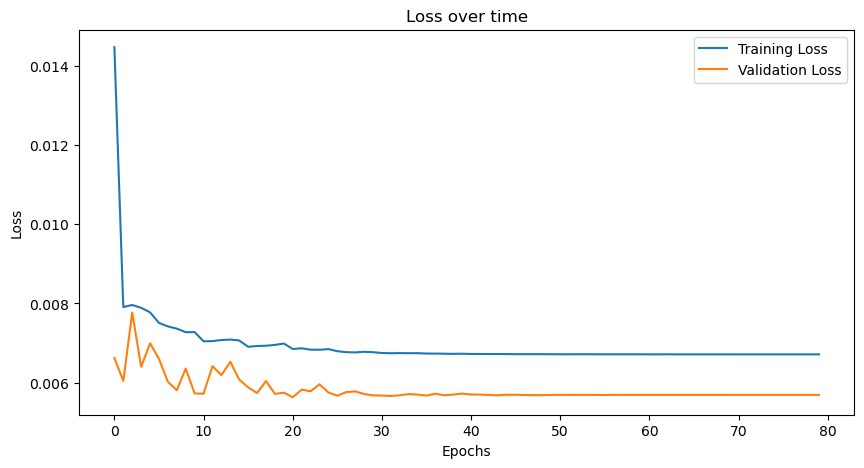

Mean Squared Error on Test Data: 65.45349
Kling-Gupta efficiency on Test Data: 0.9455789182396235


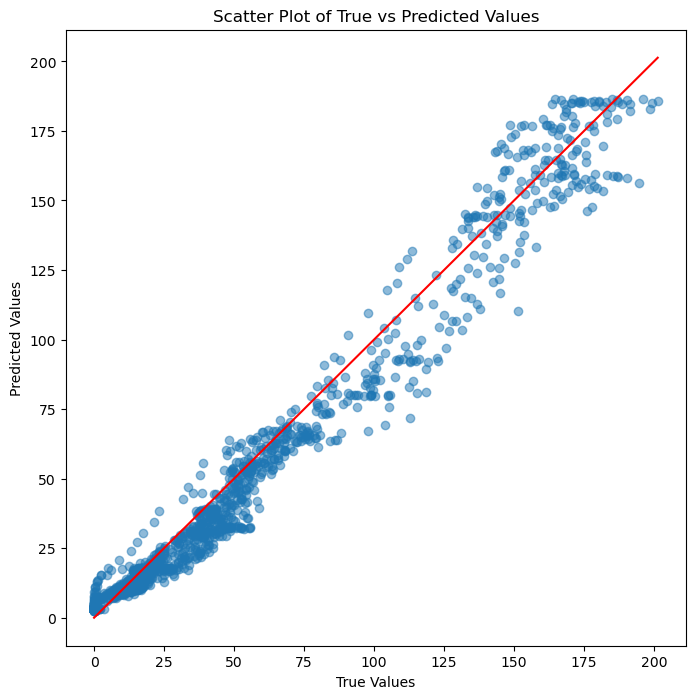

In [131]:
train(['HS'], 0, hidden_dims=[70, 45, 20], num_epochs=80, df=df_3, df_test=df_test_3, scaler_y=scaler_y_dict[3])

snow_1

Epoch 1/100, Train Loss: 0.027607777762094856, Val Loss: 0.0024158438177011876
Epoch 2/100, Train Loss: 0.0023349298889720773, Val Loss: 0.0023271545246163535
Epoch 3/100, Train Loss: 0.002243880401145619, Val Loss: 0.0023404266200599943
Epoch 4/100, Train Loss: 0.0023225033465900775, Val Loss: 0.003106102259937562
Epoch 5/100, Train Loss: 0.002489720513972218, Val Loss: 0.00221091689114247
Epoch 6/100, Train Loss: 0.0021745522904245765, Val Loss: 0.0021830796329564387
Epoch 7/100, Train Loss: 0.002169297736781637, Val Loss: 0.0021999451605595106
Epoch 8/100, Train Loss: 0.002236496842997908, Val Loss: 0.0022867312108250455
Epoch 9/100, Train Loss: 0.0022020974034611374, Val Loss: 0.0022571395553024924
Epoch 10/100, Train Loss: 0.002140866422150364, Val Loss: 0.0024435246612101217
Epoch 11/100, Train Loss: 0.002116489868067493, Val Loss: 0.0022425103619346963
Epoch 12/100, Train Loss: 0.002056846006317744, Val Loss: 0.0021335690762935597
Epoch 13/100, Train Loss: 0.002070375155185873, 

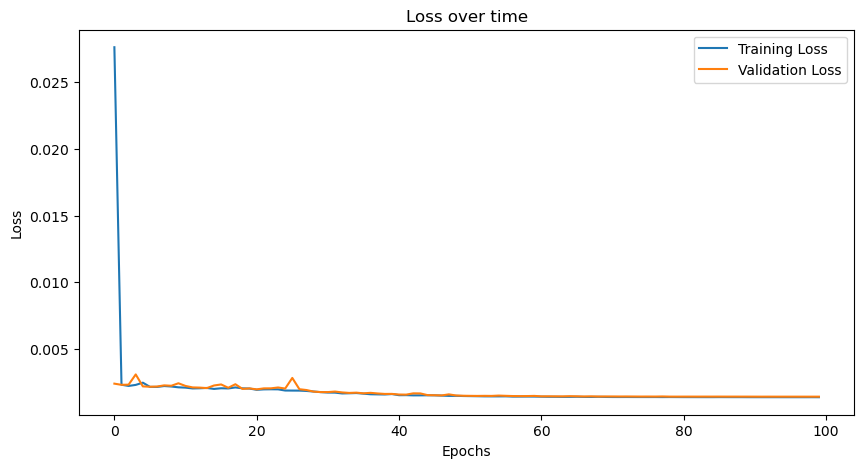

Mean Squared Error on Test Data: 30.087685
Kling-Gupta efficiency on Test Data: 0.9415964032951882


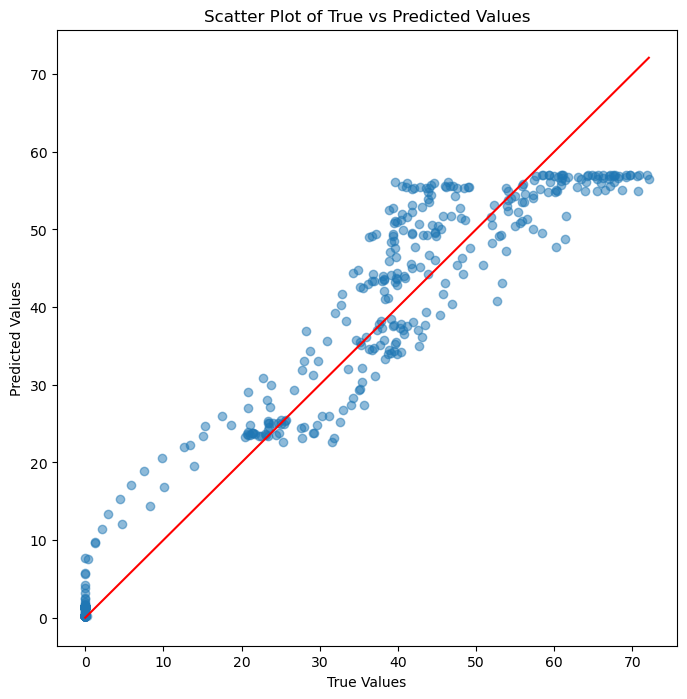

LSTM(
  (lstm1): LSTM(1, 70, batch_first=True)
  (lstm2): LSTM(70, 50, batch_first=True)
  (lstm3): LSTM(50, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [87]:
train(['HS','precipitation','snowfall','solar_radiation','rain','month'], 0, hidden_dims=[70,50,30], num_epochs=100, df=df_1, df_test=df_test_1, scaler_y=scaler_y)

# HS + temp

snow_6

Epoch 1/60, Train Loss: 0.007751953995516676, Val Loss: 0.0031423963591166617
Epoch 2/60, Train Loss: 0.0029294484178389573, Val Loss: 0.0025989400761008002
Epoch 3/60, Train Loss: 0.002462280120167746, Val Loss: 0.002339919780730416
Epoch 4/60, Train Loss: 0.002596678131656111, Val Loss: 0.001974244164992381
Epoch 5/60, Train Loss: 0.002126576373975261, Val Loss: 0.0022639984182003824
Epoch 6/60, Train Loss: 0.0024745357383528684, Val Loss: 0.0018893423080654673
Epoch 7/60, Train Loss: 0.002169246414917027, Val Loss: 0.002359798962456014
Epoch 8/60, Train Loss: 0.002284115326294028, Val Loss: 0.0018981071522078444
Epoch 9/60, Train Loss: 0.0022627210052896625, Val Loss: 0.0018959253516055204
Epoch 10/60, Train Loss: 0.0020192280070873156, Val Loss: 0.002006429375658791
Epoch 11/60, Train Loss: 0.0019517550304084502, Val Loss: 0.001972559007489995
Epoch 12/60, Train Loss: 0.0019761809818925734, Val Loss: 0.001826841710924102
Epoch 13/60, Train Loss: 0.001984320740756512, Val Loss: 0.00

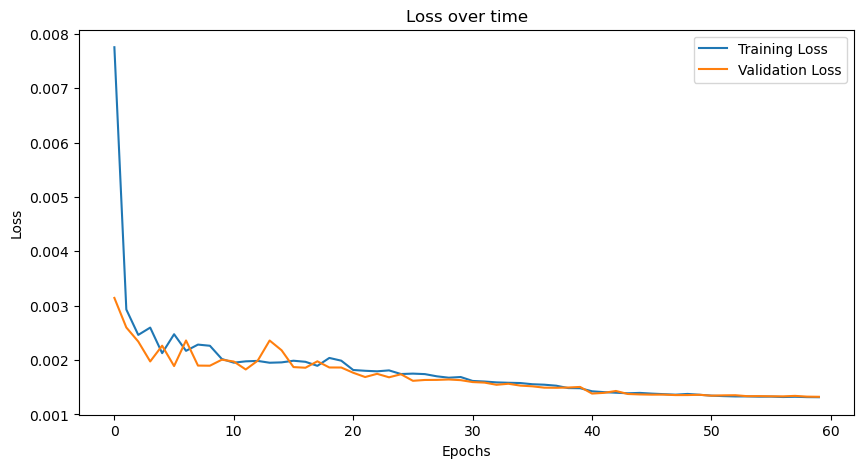

Mean Squared Error on Test Data: 58.511467
Kling-Gupta efficiency on Test Data: nan


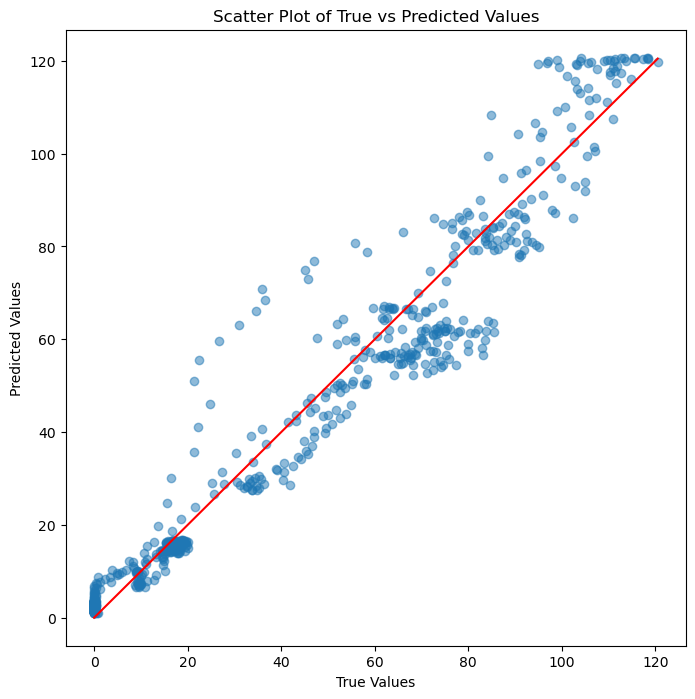

In [63]:
train(['HS','temperature'], 1, hidden_dims=[60, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

Epoch 1/60, Train Loss: 0.010738355124257084, Val Loss: 0.0025483529262216656
Epoch 2/60, Train Loss: 0.0025895524240090715, Val Loss: 0.004235644298962024
Epoch 3/60, Train Loss: 0.002756166316853974, Val Loss: 0.0035390809401542583
Epoch 4/60, Train Loss: 0.0025723315134160733, Val Loss: 0.003775967815552033
Epoch 5/60, Train Loss: 0.0022561105708457257, Val Loss: 0.0038722229822348323
Epoch 6/60, Train Loss: 0.0022731910426393993, Val Loss: 0.002069731357763317
Epoch 7/60, Train Loss: 0.002297664934084511, Val Loss: 0.003206461561677821
Epoch 8/60, Train Loss: 0.0024222523796955213, Val Loss: 0.0020289326918053172
Epoch 9/60, Train Loss: 0.002286884229521558, Val Loss: 0.0029139320662308257
Epoch 10/60, Train Loss: 0.002254088890827594, Val Loss: 0.0019046823868651872
Epoch 11/60, Train Loss: 0.002043148313112641, Val Loss: 0.0019174550043260083
Epoch 12/60, Train Loss: 0.002007457762757968, Val Loss: 0.0019632567377840466
Epoch 13/60, Train Loss: 0.0020125728764266264, Val Loss: 0.

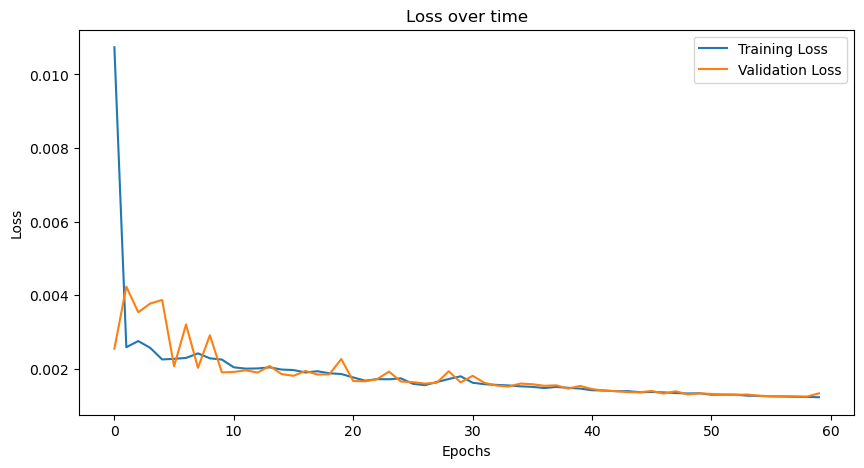

Mean Squared Error on Test Data: 59.099945
Kling-Gupta efficiency on Test Data: nan


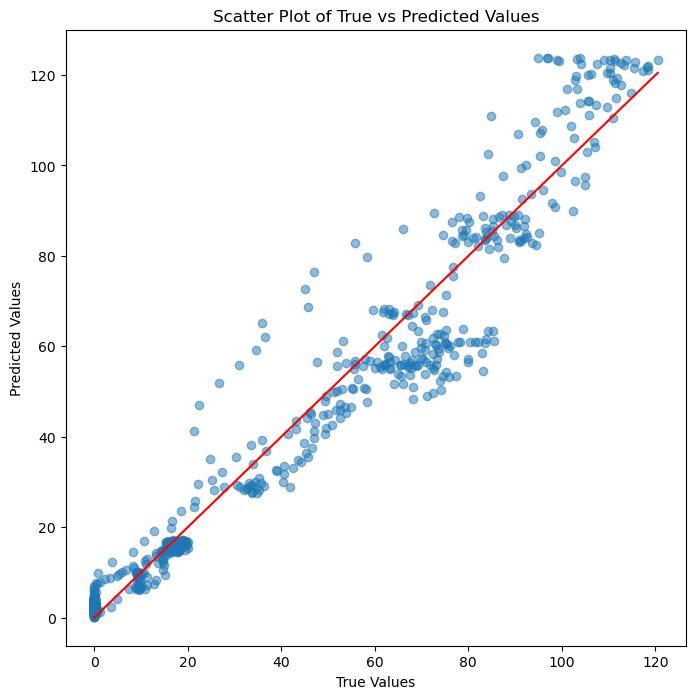

In [78]:
train(['HS','temperature'], 1, hidden_dims=[70, 50, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_3

Epoch 1/80, Train Loss: 0.01830616213991649, Val Loss: 0.006493072680407955
Epoch 2/80, Train Loss: 0.007699338888375147, Val Loss: 0.007451793166898912
Epoch 3/80, Train Loss: 0.008141833209433413, Val Loss: 0.005974822088835701
Epoch 4/80, Train Loss: 0.007499773612492466, Val Loss: 0.005843467737037328
Epoch 5/80, Train Loss: 0.007541196809027756, Val Loss: 0.005986793288179943
Epoch 6/80, Train Loss: 0.007252720896458318, Val Loss: 0.006267414749750206
Epoch 7/80, Train Loss: 0.007131899881031577, Val Loss: 0.005848169044381187
Epoch 8/80, Train Loss: 0.007158200816146855, Val Loss: 0.005841689040103266
Epoch 9/80, Train Loss: 0.007334271104986793, Val Loss: 0.005999261638029448
Epoch 10/80, Train Loss: 0.0071773622162441654, Val Loss: 0.006029419907398762
Epoch 11/80, Train Loss: 0.0070879423250072154, Val Loss: 0.006114333925107795
Epoch 12/80, Train Loss: 0.007020385819393315, Val Loss: 0.005676584083947443
Epoch 13/80, Train Loss: 0.007014666538899035, Val Loss: 0.0057847667906

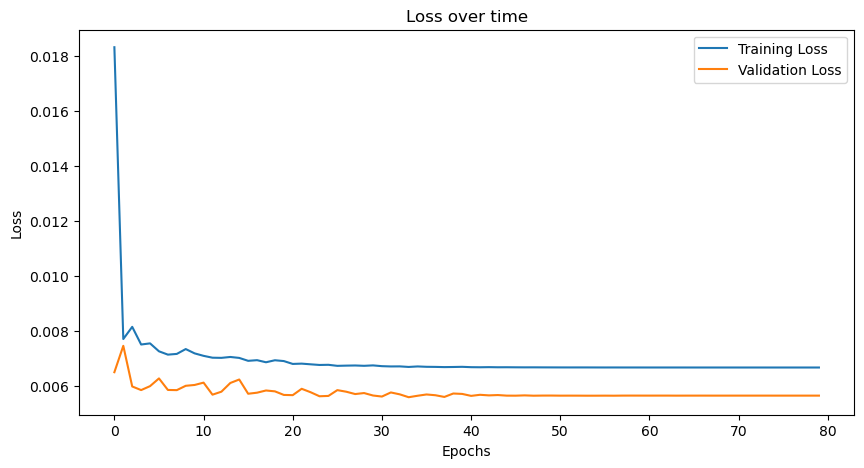

Mean Squared Error on Test Data: 74.29961
Kling-Gupta efficiency on Test Data: 0.9486511798079285


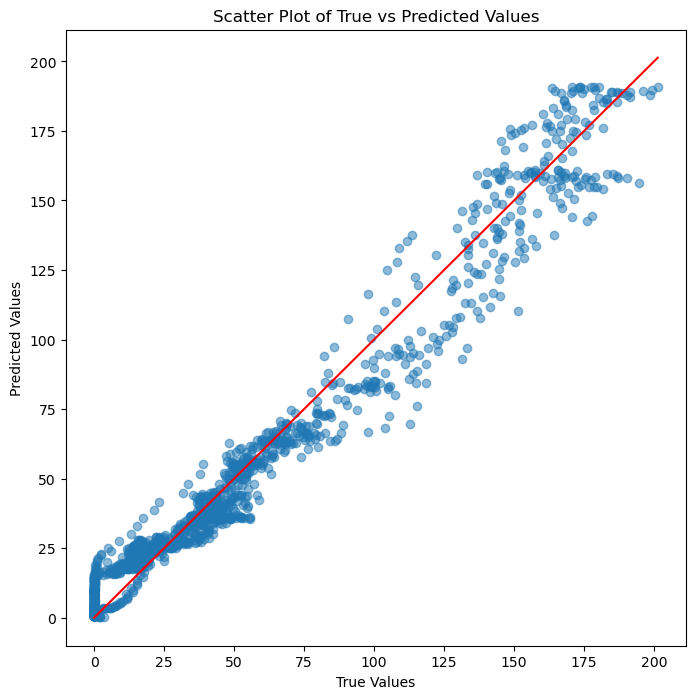

In [132]:
train(['HS','temperature'], 1, hidden_dims=[70, 45, 20], num_epochs=80, df=df_3, df_test=df_test_3, scaler_y=scaler_y_dict[3])

snow_1

Epoch 1/100, Train Loss: 0.021949008386182425, Val Loss: 0.0026154112632390384
Epoch 2/100, Train Loss: 0.002226976140765993, Val Loss: 0.0022597346930512798
Epoch 3/100, Train Loss: 0.002088141741327014, Val Loss: 0.0020749589864987993
Epoch 4/100, Train Loss: 0.002125063492984475, Val Loss: 0.002084644864685034
Epoch 5/100, Train Loss: 0.0020502151292848677, Val Loss: 0.0020526626929760683
Epoch 6/100, Train Loss: 0.0019479423551520437, Val Loss: 0.0018533589237453537
Epoch 7/100, Train Loss: 0.0019297245942863591, Val Loss: 0.002107776018547078
Epoch 8/100, Train Loss: 0.0018569530443540202, Val Loss: 0.002273737368385743
Epoch 9/100, Train Loss: 0.001919173707689914, Val Loss: 0.001797451108969876
Epoch 10/100, Train Loss: 0.0018085443840438076, Val Loss: 0.001718177587641283
Epoch 11/100, Train Loss: 0.0017398558856815483, Val Loss: 0.0016542085196099407
Epoch 12/100, Train Loss: 0.0017097236093457453, Val Loss: 0.00174189786448707
Epoch 13/100, Train Loss: 0.0016770907720678801, 

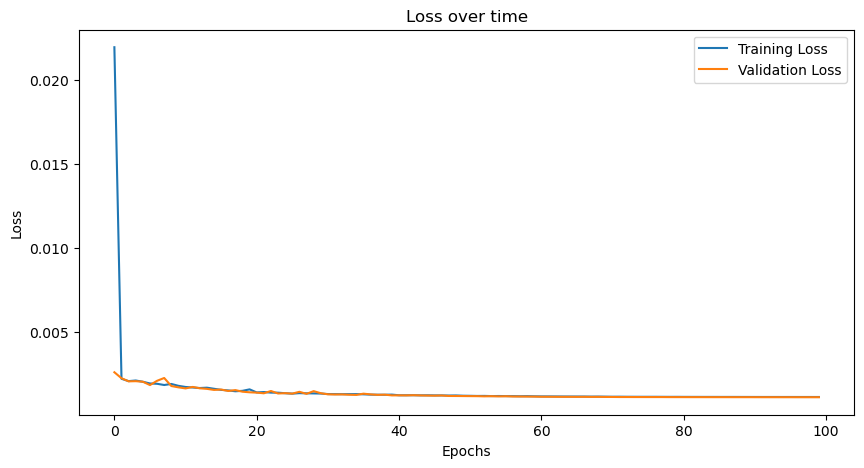

Mean Squared Error on Test Data: 30.59586
Kling-Gupta efficiency on Test Data: 0.9107750931454437


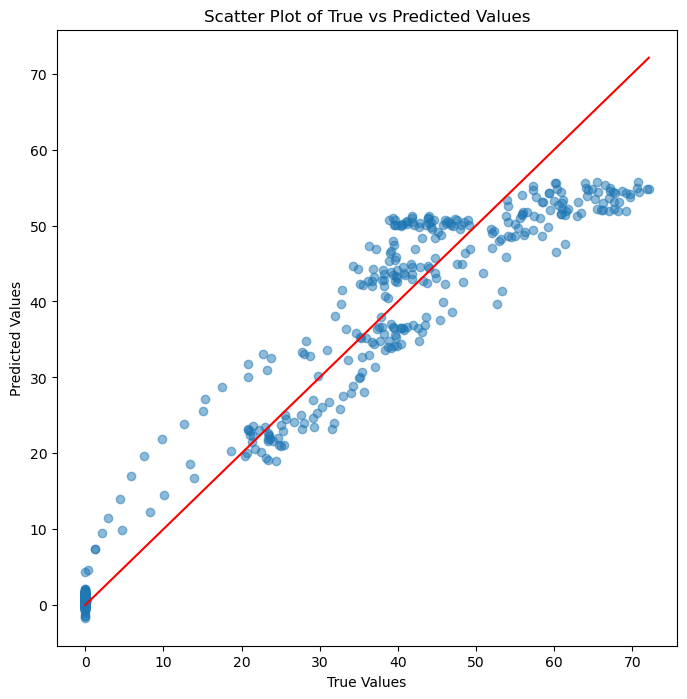

LSTM(
  (lstm1): LSTM(2, 70, batch_first=True)
  (lstm2): LSTM(70, 50, batch_first=True)
  (lstm3): LSTM(50, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [88]:
train(['HS','temperature'], 1, hidden_dims=[70, 50, 30], num_epochs=100, df=df_1, df_test=df_test_1, scaler_y=scaler_y)

# HS + snowfall

snow_6

Epoch 1/60, Train Loss: 0.012231624288802296, Val Loss: 0.00254962421104153
Epoch 2/60, Train Loss: 0.0027966695965339, Val Loss: 0.002651348353656876
Epoch 3/60, Train Loss: 0.0027525423165764822, Val Loss: 0.004837983817801608
Epoch 4/60, Train Loss: 0.0029029098080548283, Val Loss: 0.002282105856446533
Epoch 5/60, Train Loss: 0.0025397013615638046, Val Loss: 0.0026192005377244135
Epoch 6/60, Train Loss: 0.002509692950826255, Val Loss: 0.002460973024417365
Epoch 7/60, Train Loss: 0.0025936988628016016, Val Loss: 0.0023608466357908854
Epoch 8/60, Train Loss: 0.002402406527369822, Val Loss: 0.002377409027413777
Epoch 9/60, Train Loss: 0.00263093207779351, Val Loss: 0.0022083080531164557
Epoch 10/60, Train Loss: 0.002551706128320195, Val Loss: 0.0020905391712190404
Epoch 11/60, Train Loss: 0.0022492511631743315, Val Loss: 0.0021003076138846584
Epoch 12/60, Train Loss: 0.0022655968935406503, Val Loss: 0.0020598706087025078
Epoch 13/60, Train Loss: 0.0022850045602747626, Val Loss: 0.00207

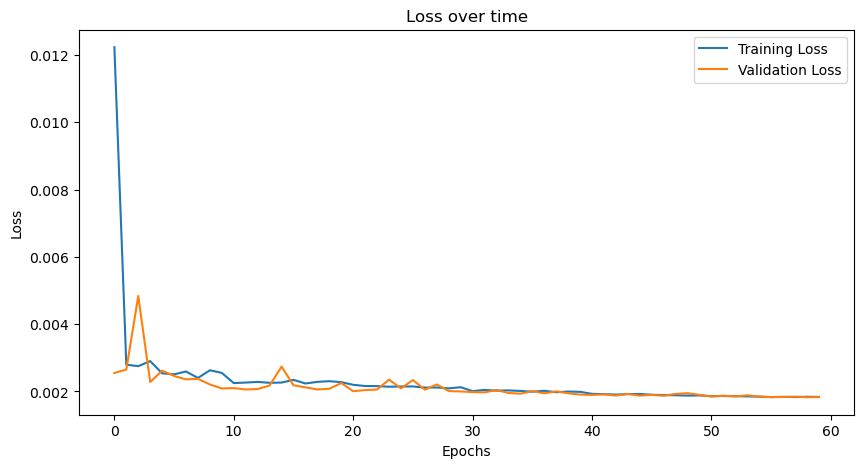

Mean Squared Error on Test Data: 29.261738
Kling-Gupta efficiency on Test Data: nan


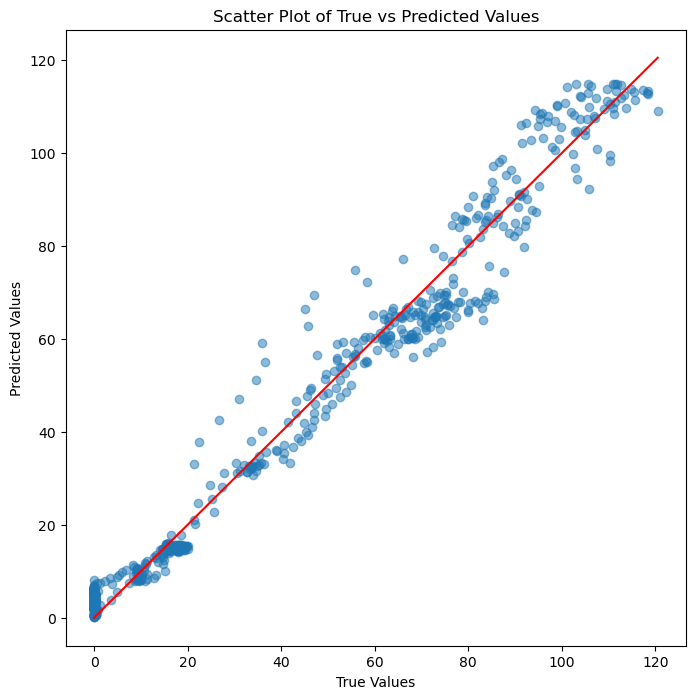

In [68]:
train(['HS','snowfall'], 1, hidden_dims=[60, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

3 layer lstm 70 50 30

In [ ]:
train(['HS','snowfall'], 1, hidden_dims=[70, 50, 30], num_epochs=100, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_3

Epoch 1/80, Train Loss: 0.029835354715669896, Val Loss: 0.006625952811971788
Epoch 2/80, Train Loss: 0.008253163355910028, Val Loss: 0.010131709307672517
Epoch 3/80, Train Loss: 0.008118403895101881, Val Loss: 0.0059740292599364635
Epoch 4/80, Train Loss: 0.007499533557333804, Val Loss: 0.006706317835637639
Epoch 5/80, Train Loss: 0.00742357545190275, Val Loss: 0.006079161508129008
Epoch 6/80, Train Loss: 0.007223066513233422, Val Loss: 0.005916620857052264
Epoch 7/80, Train Loss: 0.007179856394125183, Val Loss: 0.006398615277101917
Epoch 8/80, Train Loss: 0.007070228132540307, Val Loss: 0.005788431728198644
Epoch 9/80, Train Loss: 0.00719281760795317, Val Loss: 0.005751876424877875
Epoch 10/80, Train Loss: 0.007200475676170129, Val Loss: 0.0067653633834373565
Epoch 11/80, Train Loss: 0.006883519683619533, Val Loss: 0.006786859582268423
Epoch 12/80, Train Loss: 0.00696090566703961, Val Loss: 0.006123323867758435
Epoch 13/80, Train Loss: 0.0068727643503427895, Val Loss: 0.00626629343737

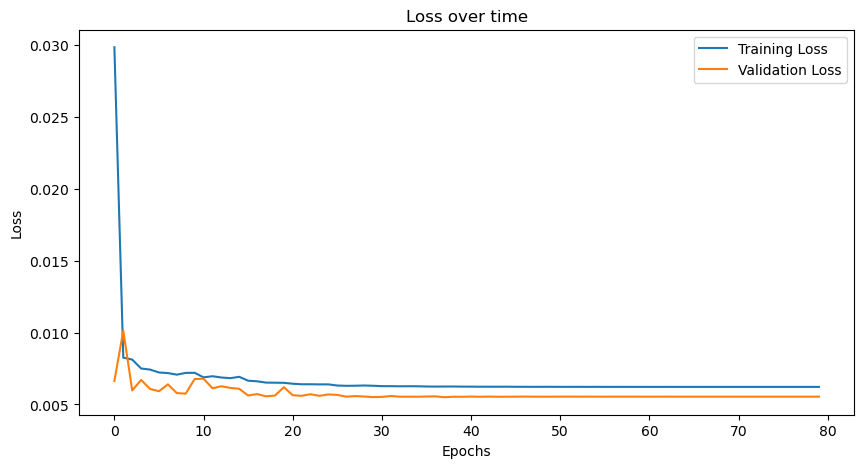

Mean Squared Error on Test Data: 76.47335
Kling-Gupta efficiency on Test Data: 0.9211823893957743


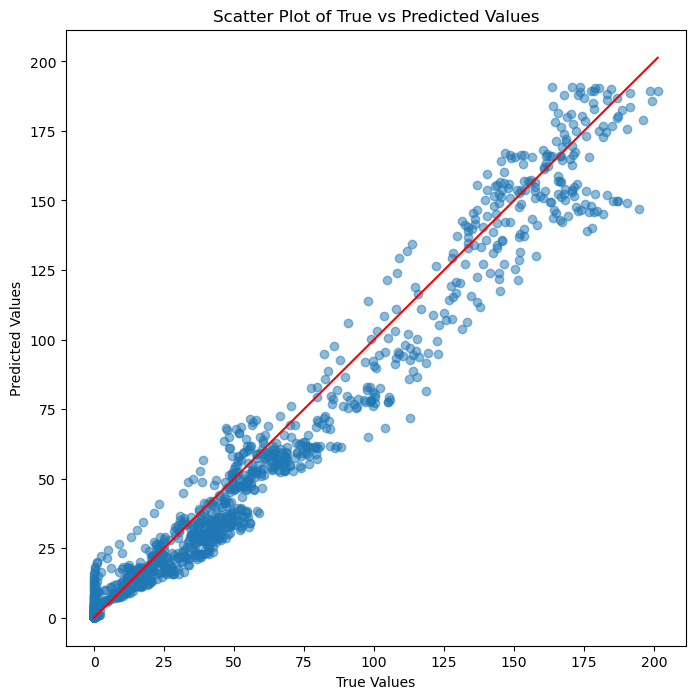

In [133]:
train(['HS','snowfall'], 1, hidden_dims=[70, 45, 20], num_epochs=80, df=df_3, df_test=df_test_3, scaler_y=scaler_y_dict[3])

snow_1

Epoch 1/100, Train Loss: 0.030351951496491746, Val Loss: 0.0025140773604899773
Epoch 2/100, Train Loss: 0.002237250687366615, Val Loss: 0.002243545994786106
Epoch 3/100, Train Loss: 0.0022440847916760415, Val Loss: 0.002487130945972107
Epoch 4/100, Train Loss: 0.002263563336572678, Val Loss: 0.002241991365492312
Epoch 5/100, Train Loss: 0.0023528491154856694, Val Loss: 0.002349588882663715
Epoch 6/100, Train Loss: 0.002243395328377833, Val Loss: 0.0021482906668035258
Epoch 7/100, Train Loss: 0.002176439403975982, Val Loss: 0.0023485909579841363
Epoch 8/100, Train Loss: 0.0022513440726205005, Val Loss: 0.002337383873492895
Epoch 9/100, Train Loss: 0.0023263735126088426, Val Loss: 0.0026452709442052525
Epoch 10/100, Train Loss: 0.0021252088124819836, Val Loss: 0.0021480157617639445
Epoch 11/100, Train Loss: 0.002074673042788526, Val Loss: 0.0020501732524952055
Epoch 12/100, Train Loss: 0.0020185455023371034, Val Loss: 0.002030967220428196
Epoch 13/100, Train Loss: 0.0020245332188920276, 

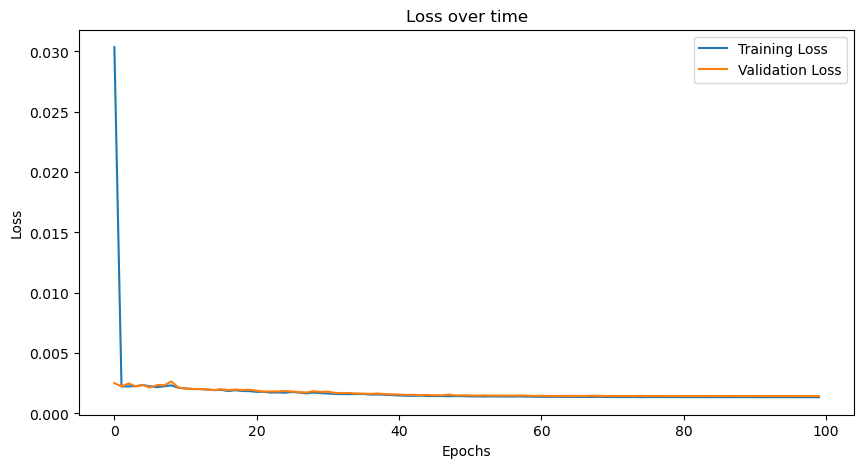

Mean Squared Error on Test Data: 32.454357
Kling-Gupta efficiency on Test Data: 0.9411635825708207


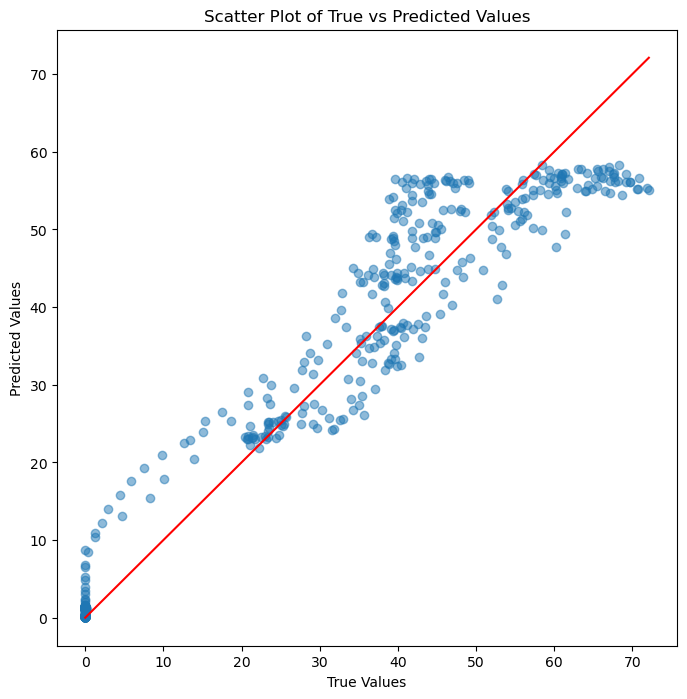

In [95]:
model = train(['HS','snowfall'], 1, hidden_dims=[70, 40, 10], num_epochs=100, df=df_1, df_test=df_test_1, scaler_y=scaler_y)

Epoch 1/100, Train Loss: 0.036399405512782895, Val Loss: 0.002944632168147761
Epoch 2/100, Train Loss: 0.002799276025494153, Val Loss: 0.0035585162050966093
Epoch 3/100, Train Loss: 0.0030903419187939987, Val Loss: 0.003590471904960665
Epoch 4/100, Train Loss: 0.0025383129434124467, Val Loss: 0.0024444144262128825
Epoch 5/100, Train Loss: 0.0026096354066813964, Val Loss: 0.0024775773574610125
Epoch 6/100, Train Loss: 0.0024381448274933986, Val Loss: 0.0024615867283243223
Epoch 7/100, Train Loss: 0.002345435622511951, Val Loss: 0.0025583689417809953
Epoch 8/100, Train Loss: 0.0023581494926974626, Val Loss: 0.0025839893026936944
Epoch 9/100, Train Loss: 0.0022985756627080136, Val Loss: 0.002479370908667793
Epoch 10/100, Train Loss: 0.0025165938464485013, Val Loss: 0.0027466880431390754
Epoch 11/100, Train Loss: 0.0022904707581532296, Val Loss: 0.0023164753091637477
Epoch 12/100, Train Loss: 0.0022678968149872874, Val Loss: 0.0023501999690217395
Epoch 13/100, Train Loss: 0.002244940876277

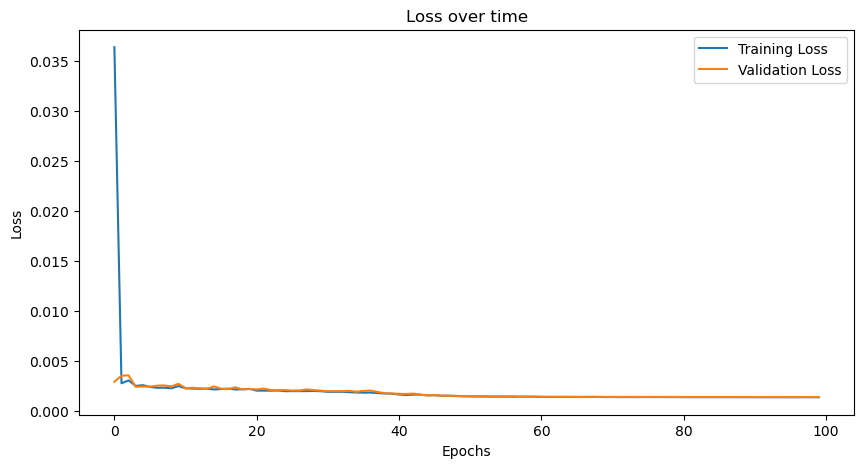

Mean Squared Error on Test Data: 31.578068
Kling-Gupta efficiency on Test Data: 0.9402584301867629


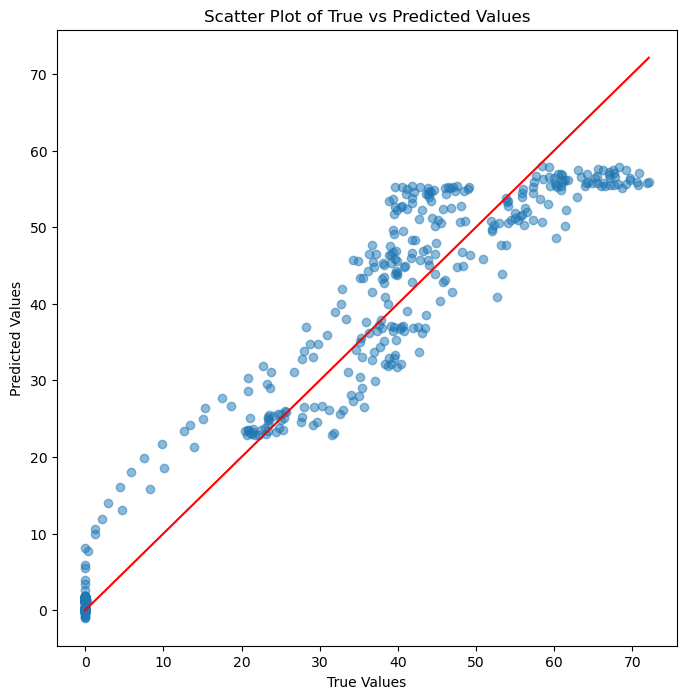

In [35]:
model = train(['HS','snowfall'], 1, hidden_dims=50, num_epochs=100, df=df_1, df_test=df_test_1)

In [36]:
input_values, target_values = rebuild_data(df_1, ['HS','snowfall'], 90)
X_test_90, y_test_90 = rebuild_data(df_test_1, ['HS','snowfall'], 90)
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

# dataloader
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 1, batch_size=32)

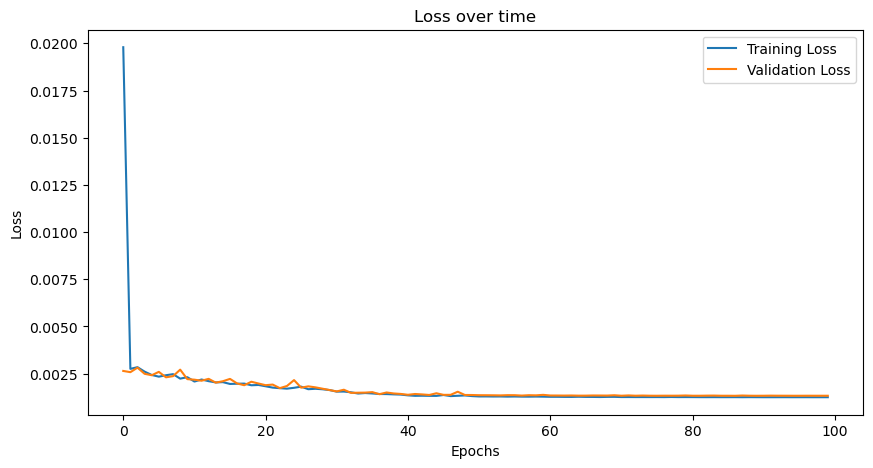

In [100]:
# Plot the loss function
plot_loss(train_losses, val_losses)

Mean Squared Error on Test Data: 19.660812


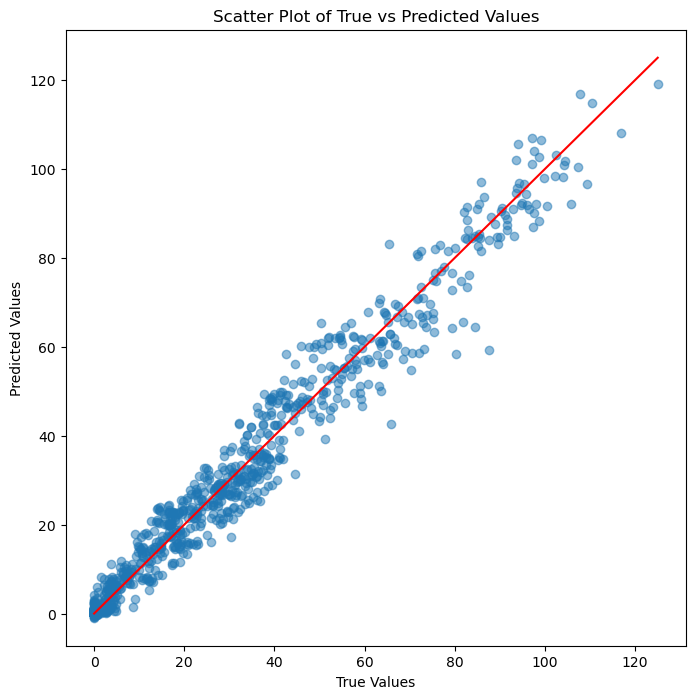

In [101]:
evaluate_model(test_loader, model_3, scaler_y)

In [113]:
torch.save(model_3.state_dict(), f"/Users/yz6622/Desktop/IRP/models/sc_1_hs+snowfall.pth")

In [ ]:
model_dict=torch.load("/Users/yz6622/Desktop/IRP/models/sc_1_hs+snowfall.pth")

In [ ]:
model_dict

# HS + rain

snow_6

Epoch 1/60, Train Loss: 0.01027373527892406, Val Loss: 0.005930214417441614
Epoch 2/60, Train Loss: 0.002708217318121863, Val Loss: 0.002980305841882039
Epoch 3/60, Train Loss: 0.0031925938409137324, Val Loss: 0.0028983798220407783
Epoch 4/60, Train Loss: 0.0028113973113139124, Val Loss: 0.0023114268863433447
Epoch 5/60, Train Loss: 0.002538465666163998, Val Loss: 0.003428853977847858
Epoch 6/60, Train Loss: 0.0025182072788364766, Val Loss: 0.0022703145034412573
Epoch 7/60, Train Loss: 0.0025579354096521884, Val Loss: 0.0026182515347736375
Epoch 8/60, Train Loss: 0.0024935374958989873, Val Loss: 0.0020966454713758423
Epoch 9/60, Train Loss: 0.00240244939245536, Val Loss: 0.002192929311868135
Epoch 10/60, Train Loss: 0.0024075642128216766, Val Loss: 0.002460855953985477
Epoch 11/60, Train Loss: 0.0024128008810300823, Val Loss: 0.0021018162916018306
Epoch 12/60, Train Loss: 0.0022538086594289246, Val Loss: 0.002105497367156569
Epoch 13/60, Train Loss: 0.002317989934492889, Val Loss: 0.00

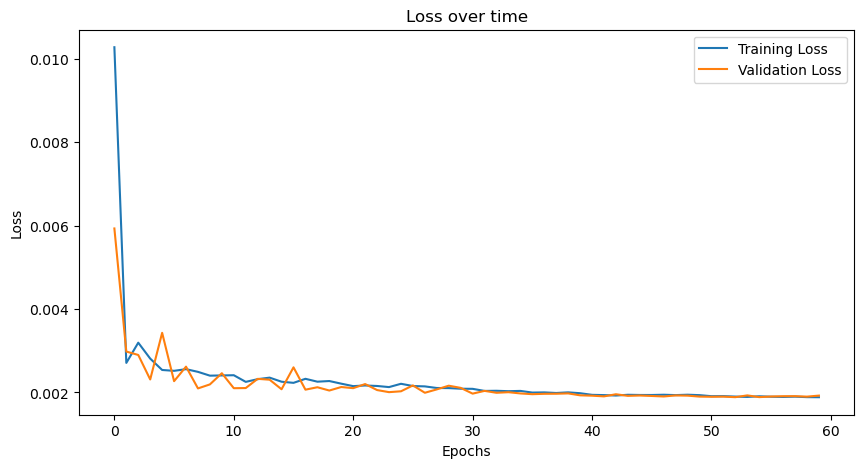

Mean Squared Error on Test Data: 38.486187
Kling-Gupta efficiency on Test Data: nan


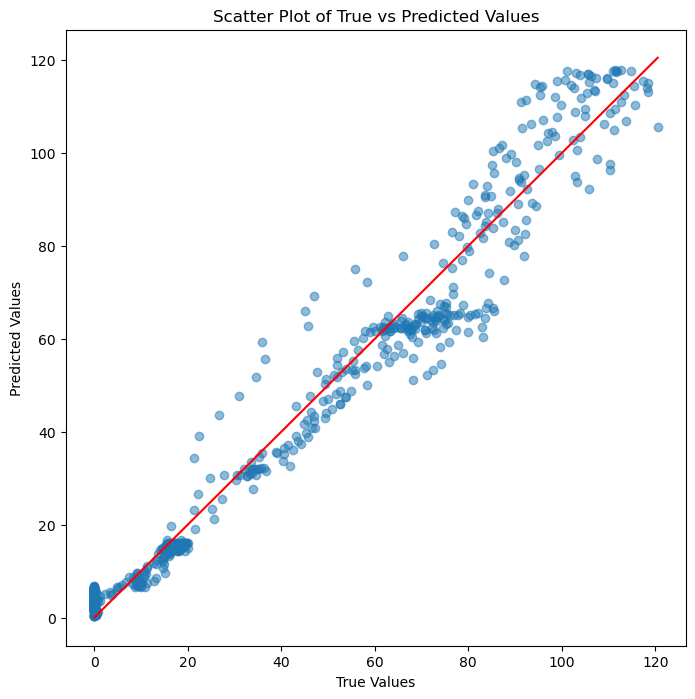

In [69]:
train(['HS','rain'], 1, hidden_dims=[60, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

3 layer lstm 70 50 30

Epoch 1/100, Train Loss: 0.031147010569912446, Val Loss: 0.0063713598846187516
Epoch 2/100, Train Loss: 0.008125999256896338, Val Loss: 0.00868708867459528
Epoch 3/100, Train Loss: 0.008336306159490535, Val Loss: 0.006073996812225349
Epoch 4/100, Train Loss: 0.007806093444787657, Val Loss: 0.006004575030097077
Epoch 5/100, Train Loss: 0.007727542179136795, Val Loss: 0.006252837678297393
Epoch 6/100, Train Loss: 0.007685794577354309, Val Loss: 0.006089339005730806
Epoch 7/100, Train Loss: 0.007679469285110392, Val Loss: 0.006338197371411708
Epoch 8/100, Train Loss: 0.00785252639664528, Val Loss: 0.006514291726653614
Epoch 9/100, Train Loss: 0.007576303635862949, Val Loss: 0.006601754122323567
Epoch 10/100, Train Loss: 0.007368435539926092, Val Loss: 0.006263175322824428
Epoch 11/100, Train Loss: 0.007323116107668676, Val Loss: 0.00601948247621617
Epoch 12/100, Train Loss: 0.007235324470276694, Val Loss: 0.005948808520371395
Epoch 13/100, Train Loss: 0.007245033552089918, Val Loss: 0.006

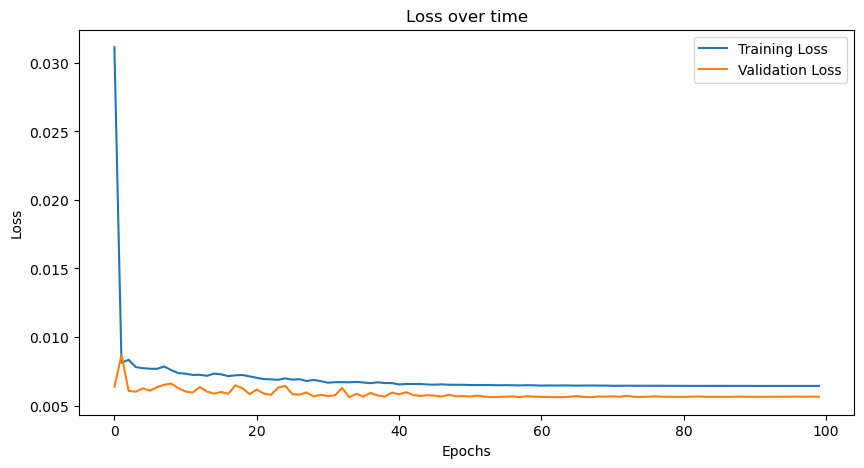

Mean Squared Error on Test Data: 70.270004


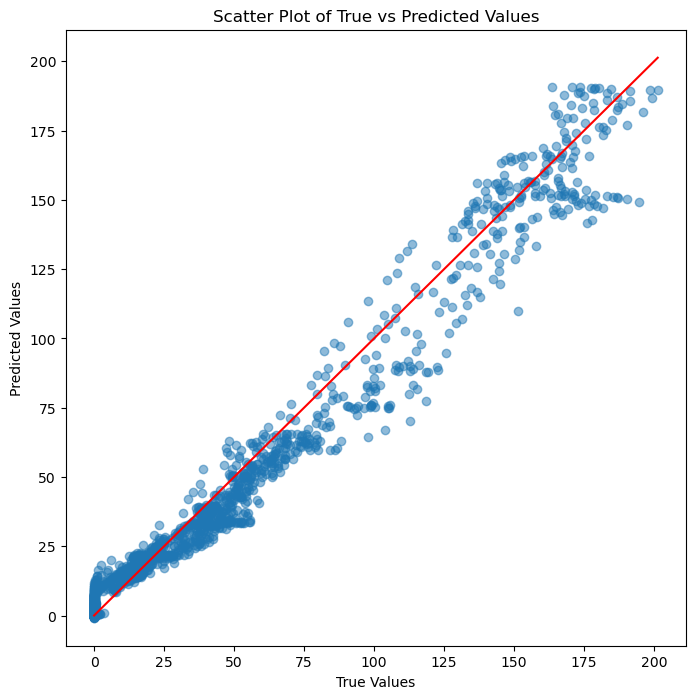

In [121]:
train(['HS','rain'], 1, hidden_dims=[70, 50, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_3

Epoch 1/80, Train Loss: 0.02120943995654174, Val Loss: 0.006485434315137325
Epoch 2/80, Train Loss: 0.007928251965336737, Val Loss: 0.006430732092309383
Epoch 3/80, Train Loss: 0.007772752759591816, Val Loss: 0.006060782539087438
Epoch 4/80, Train Loss: 0.007790769271468375, Val Loss: 0.006026491808194307
Epoch 5/80, Train Loss: 0.007837007131917617, Val Loss: 0.006495163845078599
Epoch 6/80, Train Loss: 0.007452294432661099, Val Loss: 0.007294738962645492
Epoch 7/80, Train Loss: 0.007358107849642863, Val Loss: 0.006108506234182466
Epoch 8/80, Train Loss: 0.007359020429256705, Val Loss: 0.006175035280325721
Epoch 9/80, Train Loss: 0.007444318987149519, Val Loss: 0.006049107375644868
Epoch 10/80, Train Loss: 0.007414616878152712, Val Loss: 0.00601267586612413
Epoch 11/80, Train Loss: 0.007152830697618623, Val Loss: 0.0063048216994972
Epoch 12/80, Train Loss: 0.007159986129200463, Val Loss: 0.005993041026616289
Epoch 13/80, Train Loss: 0.00717833896090154, Val Loss: 0.005858221791324116


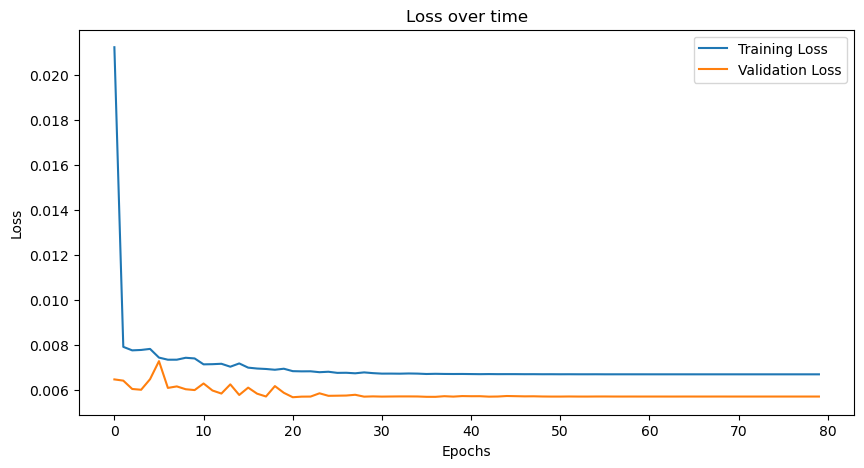

Mean Squared Error on Test Data: 64.74317
Kling-Gupta efficiency on Test Data: 0.9430524686377009


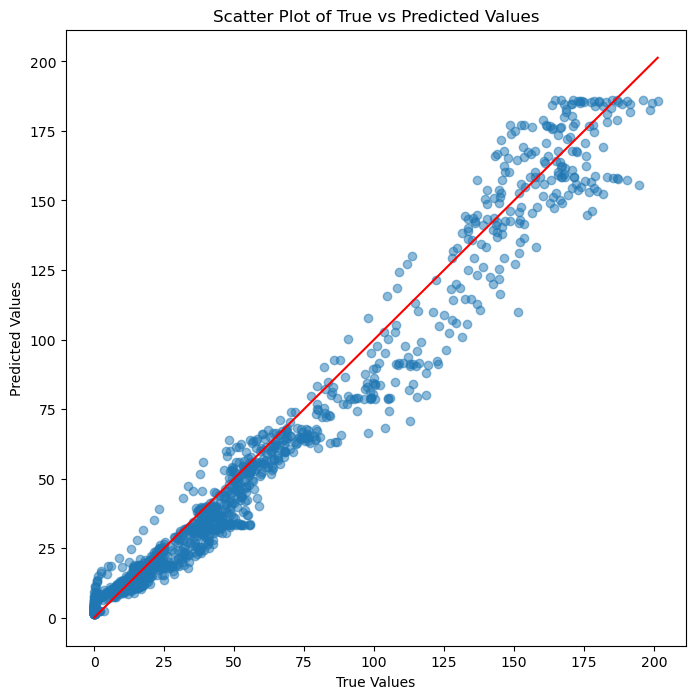

In [134]:
train(['HS','rain'], 1, hidden_dims=[70, 45, 20], num_epochs=80, df=df_3, df_test=df_test_3, scaler_y=scaler_y_dict[3])

snow_1

Epoch 1/80, Train Loss: 0.025695200842633333, Val Loss: 0.0025927275116455466
Epoch 2/80, Train Loss: 0.002460240171982431, Val Loss: 0.0022688943303146203
Epoch 3/80, Train Loss: 0.0022746960192822846, Val Loss: 0.0023018706059323166
Epoch 4/80, Train Loss: 0.002510775611316186, Val Loss: 0.0022514966030729045
Epoch 5/80, Train Loss: 0.0022717018415871607, Val Loss: 0.0032178897443607196
Epoch 6/80, Train Loss: 0.0021859981908059233, Val Loss: 0.0021585706212705743
Epoch 7/80, Train Loss: 0.002185945825395474, Val Loss: 0.002428280862643835
Epoch 8/80, Train Loss: 0.002157393548349838, Val Loss: 0.0023203566757854185
Epoch 9/80, Train Loss: 0.0022025872411630056, Val Loss: 0.0024328674870251394
Epoch 10/80, Train Loss: 0.0022105730336575164, Val Loss: 0.002162328839867652
Epoch 11/80, Train Loss: 0.0020874324364611647, Val Loss: 0.002057692499395636
Epoch 12/80, Train Loss: 0.00203535279834667, Val Loss: 0.0020644946497477305
Epoch 13/80, Train Loss: 0.0020571818823082763, Val Loss: 0

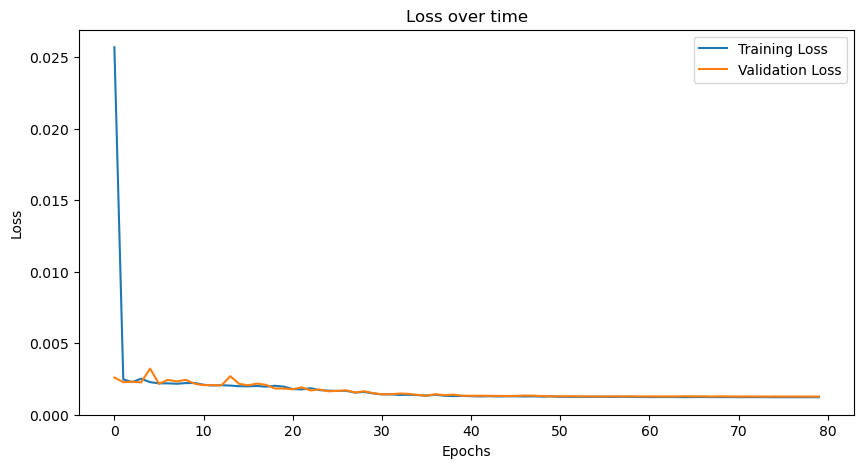

Mean Squared Error on Test Data: 30.237736
Kling-Gupta efficiency on Test Data: 0.9338868167574395


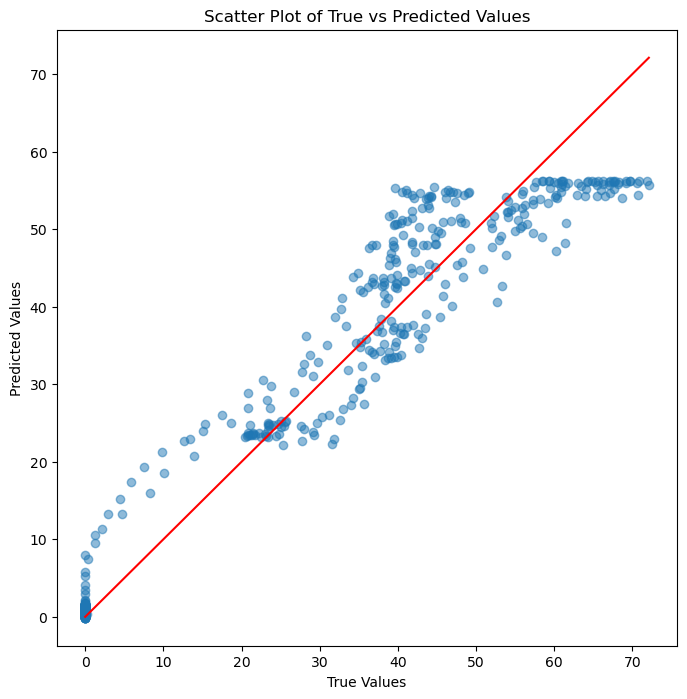

LSTM(
  (lstm1): LSTM(2, 70, batch_first=True)
  (lstm2): LSTM(70, 50, batch_first=True)
  (lstm3): LSTM(50, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [90]:
train(['HS','rain'], 1, hidden_dims=[70, 50, 30], num_epochs=80, df=df_1, df_test=df_test_1, scaler_y=scaler_y)

# HS + solar_radiation

snow_6

Epoch 1/60, Train Loss: 0.010029501776553344, Val Loss: 0.0024937203386506367
Epoch 2/60, Train Loss: 0.00259880037713034, Val Loss: 0.0030431644833287972
Epoch 3/60, Train Loss: 0.002728871280184878, Val Loss: 0.0024812916199381052
Epoch 4/60, Train Loss: 0.0026141336722909432, Val Loss: 0.003171511063085801
Epoch 5/60, Train Loss: 0.0026428983976230155, Val Loss: 0.0025721907160225015
Epoch 6/60, Train Loss: 0.002313465160584145, Val Loss: 0.002738225088867276
Epoch 7/60, Train Loss: 0.0022884973545688457, Val Loss: 0.004166969647070152
Epoch 8/60, Train Loss: 0.002442687623953, Val Loss: 0.002115552350288605
Epoch 9/60, Train Loss: 0.0024014184626235326, Val Loss: 0.0023580768485664573
Epoch 10/60, Train Loss: 0.0022884878841751117, Val Loss: 0.002327240331313448
Epoch 11/60, Train Loss: 0.0021684612308183644, Val Loss: 0.002006733012379824
Epoch 12/60, Train Loss: 0.0021700050087045024, Val Loss: 0.002102600971769677
Epoch 13/60, Train Loss: 0.002126808702404385, Val Loss: 0.002137

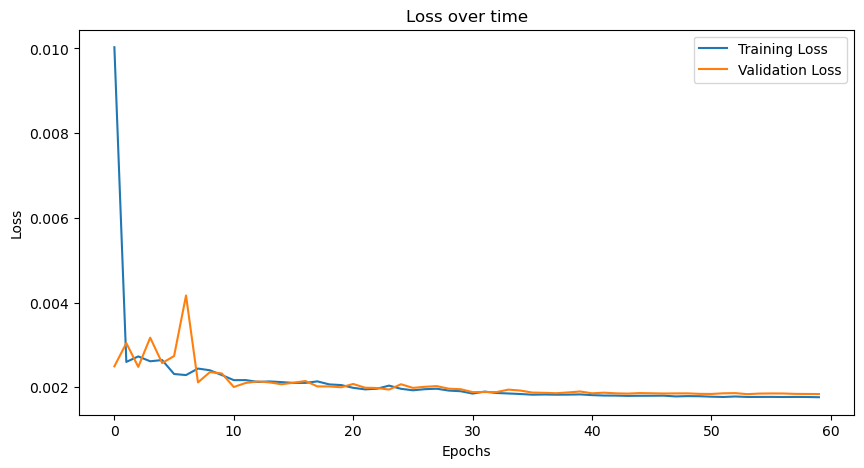

Mean Squared Error on Test Data: 32.989727
Kling-Gupta efficiency on Test Data: nan


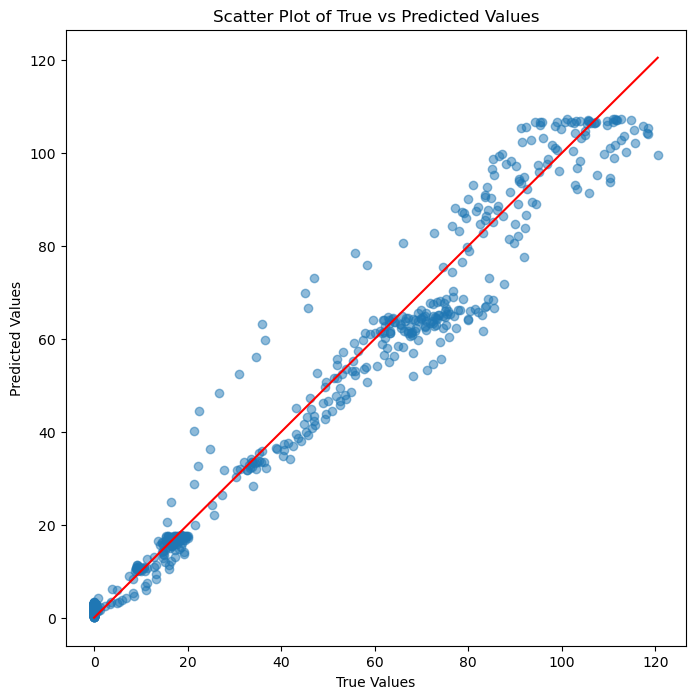

In [70]:
train(['HS','solar_radiation'], 1, hidden_dims=[60, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

3 layer lstm 70 50 30

In [ ]:
train(['HS','solar_radiation'], 1, hidden_dims=[70, 50, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_3

Epoch 1/80, Train Loss: 0.01296556228947086, Val Loss: 0.002518392438647411
Epoch 2/80, Train Loss: 0.0029439339271093365, Val Loss: 0.0031179897595253053
Epoch 3/80, Train Loss: 0.0025996523453542027, Val Loss: 0.002178991837000505
Epoch 4/80, Train Loss: 0.0028591888063964686, Val Loss: 0.002795102205033995
Epoch 5/80, Train Loss: 0.002737729087840927, Val Loss: 0.002826757899075373
Epoch 6/80, Train Loss: 0.0023386554606726283, Val Loss: 0.0026549623322111074
Epoch 7/80, Train Loss: 0.002282189753916175, Val Loss: 0.002108405996230869
Epoch 8/80, Train Loss: 0.0022238075629185177, Val Loss: 0.0021163564884668236
Epoch 9/80, Train Loss: 0.002402979278191457, Val Loss: 0.0021843360449214336
Epoch 10/80, Train Loss: 0.0022713078578543784, Val Loss: 0.002087992723356965
Epoch 11/80, Train Loss: 0.0021527391248423525, Val Loss: 0.002040877176531669
Epoch 12/80, Train Loss: 0.002118501664545981, Val Loss: 0.002104252611591926
Epoch 13/80, Train Loss: 0.002116381924119141, Val Loss: 0.0021

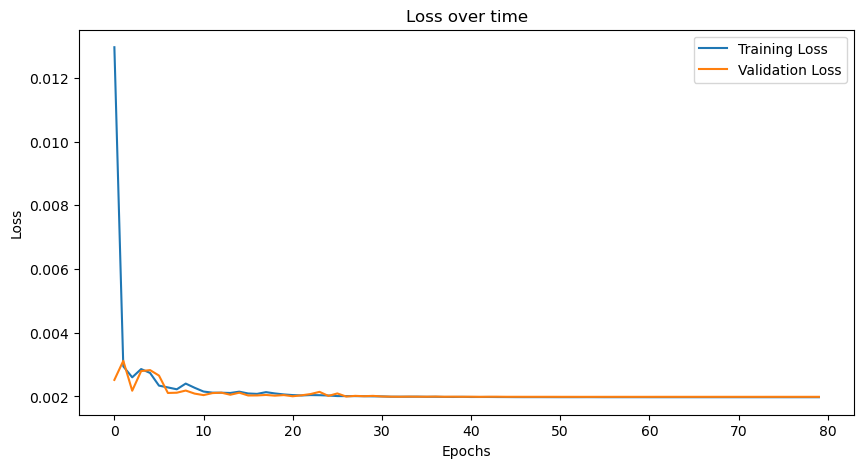

Mean Squared Error on Test Data: 42.83168
Kling-Gupta efficiency on Test Data: 0.9485958423334954


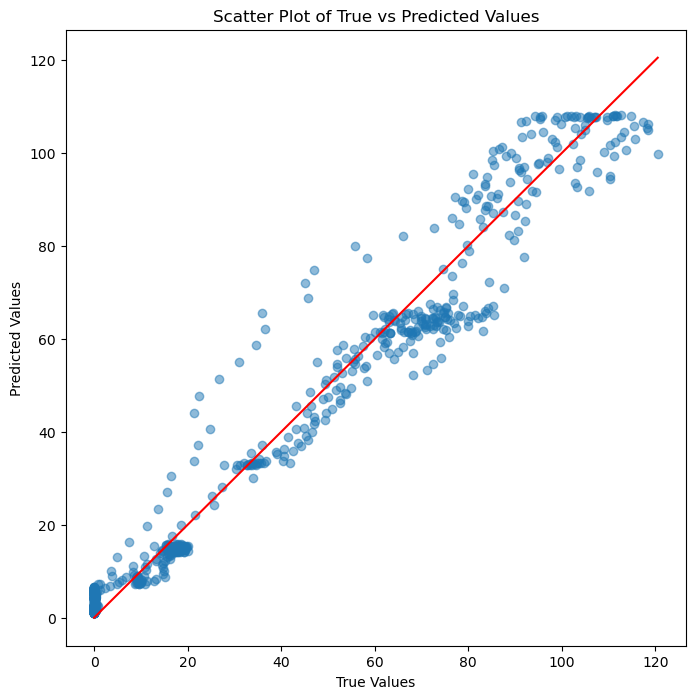

In [136]:
train(['HS','solar_radiation'], 1, hidden_dims=[70, 50, 30], num_epochs=80, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_1

Epoch 1/100, Train Loss: 0.022103057637442976, Val Loss: 0.0024708394779595884
Epoch 2/100, Train Loss: 0.0023049912134649095, Val Loss: 0.002122673959882986
Epoch 3/100, Train Loss: 0.0021092597944781886, Val Loss: 0.001983457129916312
Epoch 4/100, Train Loss: 0.0019913482166978615, Val Loss: 0.0019005014208373274
Epoch 5/100, Train Loss: 0.0019079503945031008, Val Loss: 0.0018369360860385194
Epoch 6/100, Train Loss: 0.0018422752397950306, Val Loss: 0.0017874877481689365
Epoch 7/100, Train Loss: 0.0017900035569700112, Val Loss: 0.0017525828137190398
Epoch 8/100, Train Loss: 0.0017469897006874176, Val Loss: 0.0017240005862587352
Epoch 9/100, Train Loss: 0.0017096785504706685, Val Loss: 0.0016958307145591106
Epoch 10/100, Train Loss: 0.0016780139753483077, Val Loss: 0.0016685491009583386
Epoch 11/100, Train Loss: 0.0015984932469331975, Val Loss: 0.001614916184817165
Epoch 12/100, Train Loss: 0.0015803343073820671, Val Loss: 0.0016027455515420072
Epoch 13/100, Train Loss: 0.0015664545447

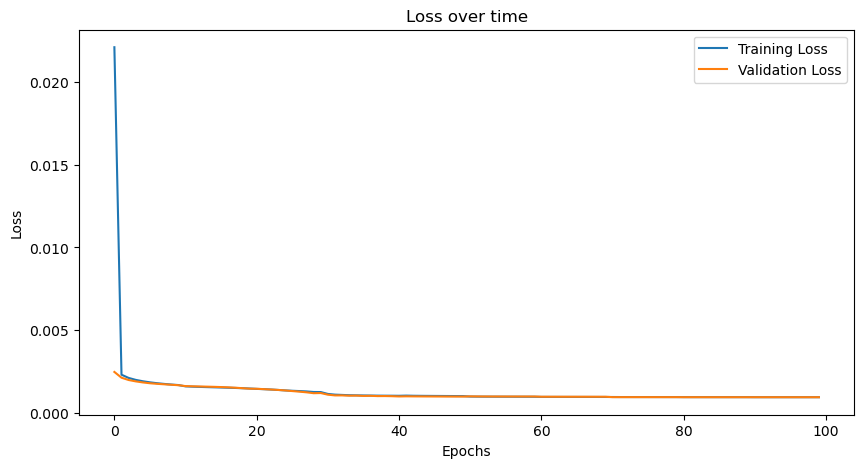

Mean Squared Error on Test Data: 40.03793
Kling-Gupta efficiency on Test Data: 0.8541741494563763


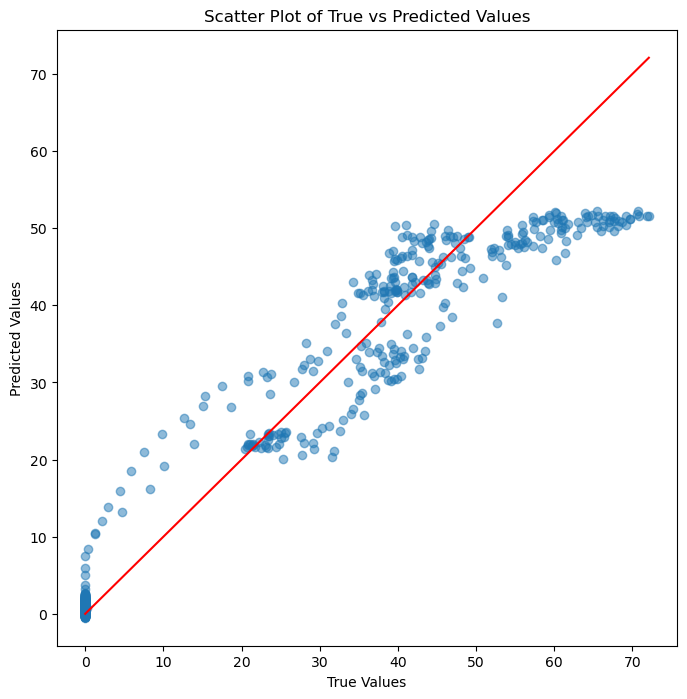

LSTM(
  (lstm1): LSTM(2, 70, batch_first=True)
  (lstm2): LSTM(70, 50, batch_first=True)
  (lstm3): LSTM(50, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [97]:
train(['HS','solar_radiation'], 1, hidden_dims=[70, 50, 30], num_epochs=100, df=df_1, df_test=df_test_1, scaler_y=scaler_y)

# HS + precipitation

snow_6

Epoch 1/60, Train Loss: 0.007924965630405801, Val Loss: 0.003390401714847165
Epoch 2/60, Train Loss: 0.0033208910403805325, Val Loss: 0.0024263202576457503
Epoch 3/60, Train Loss: 0.002847072141364198, Val Loss: 0.002612622565919372
Epoch 4/60, Train Loss: 0.0026743295035760854, Val Loss: 0.0035400707683662697
Epoch 5/60, Train Loss: 0.0026227171299686956, Val Loss: 0.0021489576810218365
Epoch 6/60, Train Loss: 0.002408810896761575, Val Loss: 0.002150432756632202
Epoch 7/60, Train Loss: 0.002738477918991312, Val Loss: 0.0022307784893109443
Epoch 8/60, Train Loss: 0.0024444734513493186, Val Loss: 0.002943451874340222
Epoch 9/60, Train Loss: 0.002492968491109151, Val Loss: 0.0023961287768034163
Epoch 10/60, Train Loss: 0.002410249422342894, Val Loss: 0.0024475114136102284
Epoch 11/60, Train Loss: 0.0022440460239451757, Val Loss: 0.0020529729560417225
Epoch 12/60, Train Loss: 0.002206623913700385, Val Loss: 0.0020334493327088927
Epoch 13/60, Train Loss: 0.0022336466353587627, Val Loss: 0.

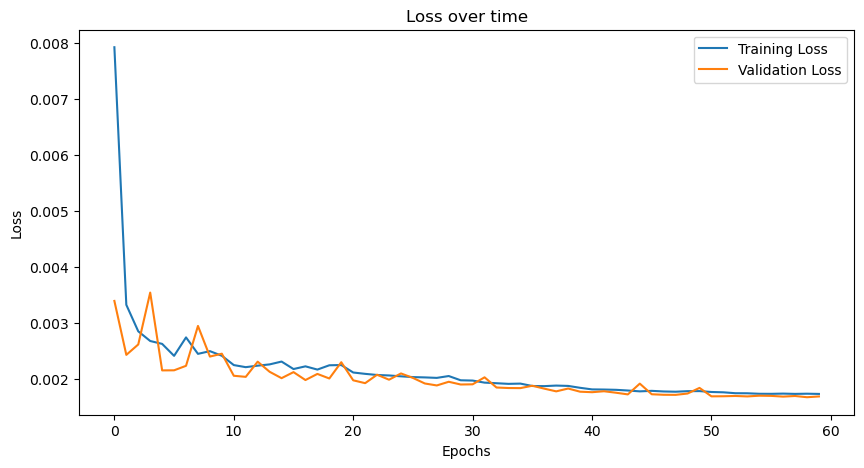

Mean Squared Error on Test Data: 34.75876
Kling-Gupta efficiency on Test Data: nan


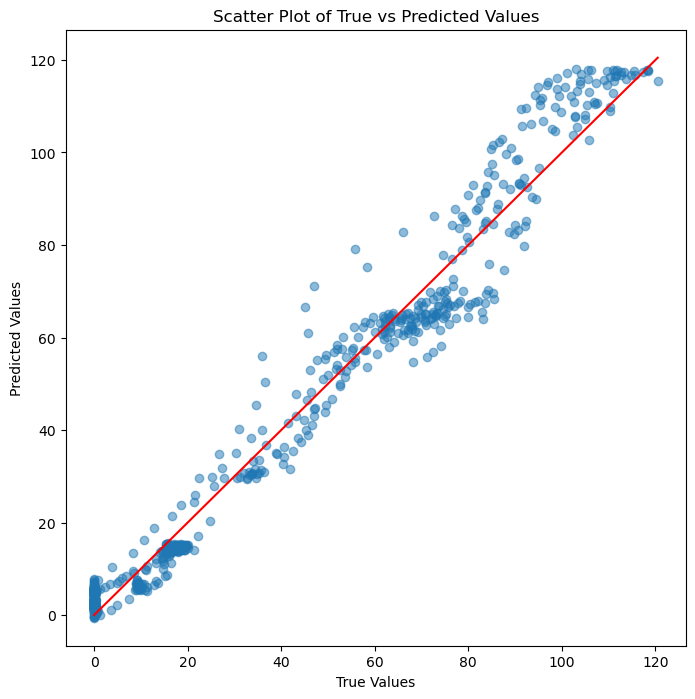

In [71]:
train(['HS','precipitation'], 1, hidden_dims=[60, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

3 layer lstm 70 50 30

Epoch 1/100, Train Loss: 0.010477146176432015, Val Loss: 0.0033291268928988442
Epoch 2/100, Train Loss: 0.0032452411933275058, Val Loss: 0.0065156339289132075
Epoch 3/100, Train Loss: 0.0029150739290554036, Val Loss: 0.002882826448607503
Epoch 4/100, Train Loss: 0.002916648595125287, Val Loss: 0.002752013468864833
Epoch 5/100, Train Loss: 0.0027594444150390827, Val Loss: 0.0036312337018843915
Epoch 6/100, Train Loss: 0.0028669787938922758, Val Loss: 0.0024736067110735695
Epoch 7/100, Train Loss: 0.0032846115270560583, Val Loss: 0.0032045769246956484
Epoch 8/100, Train Loss: 0.003161888695357033, Val Loss: 0.0022480629245461977
Epoch 9/100, Train Loss: 0.002763718764363102, Val Loss: 0.004153787419012978
Epoch 10/100, Train Loss: 0.002660444545602821, Val Loss: 0.0026782452446669153
Epoch 11/100, Train Loss: 0.0024676927372812058, Val Loss: 0.0021311652570860074
Epoch 12/100, Train Loss: 0.002374442728350834, Val Loss: 0.002520421852615932
Epoch 13/100, Train Loss: 0.0022610613506303698

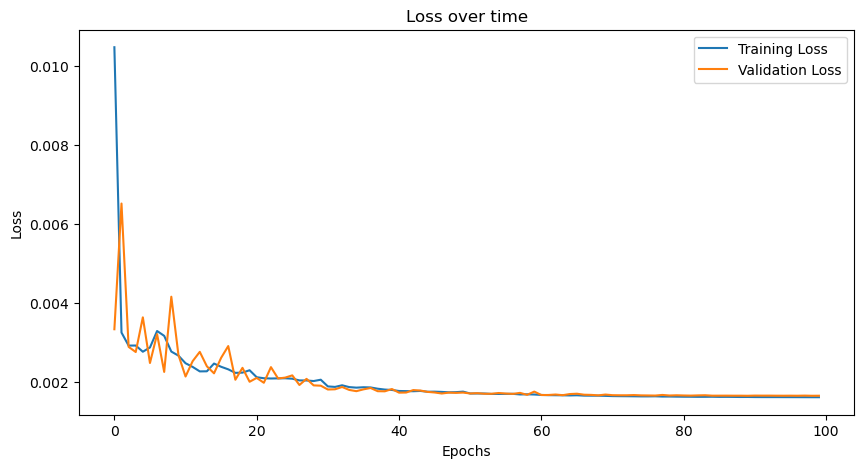

Mean Squared Error on Test Data: 26.214933


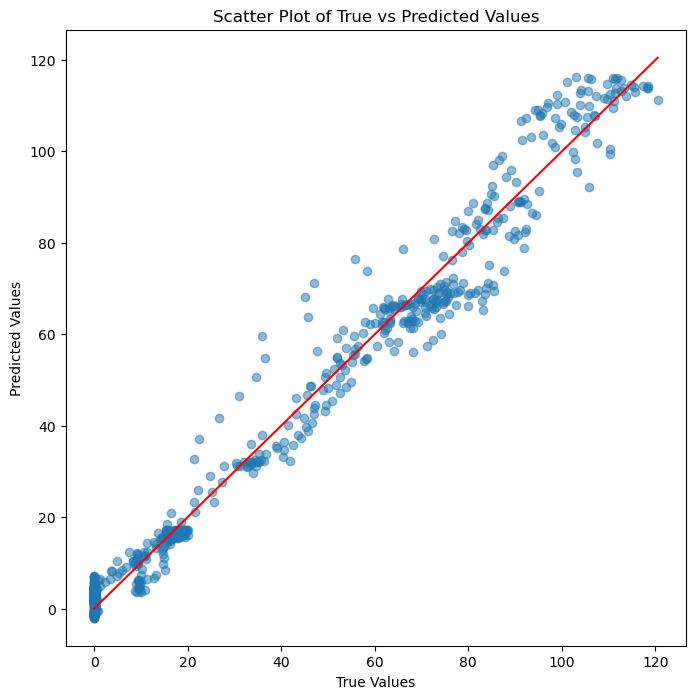

In [109]:
train(['HS','precipitation'], 1, hidden_dims=[60, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_3

Epoch 1/60, Train Loss: 0.009990809510731918, Val Loss: 0.005525561240636083
Epoch 2/60, Train Loss: 0.0027905702602627736, Val Loss: 0.0025104580599279464
Epoch 3/60, Train Loss: 0.0029477939975022607, Val Loss: 0.0022648602511986175
Epoch 4/60, Train Loss: 0.002647462355293137, Val Loss: 0.0024431274490725424
Epoch 5/60, Train Loss: 0.002667890218643932, Val Loss: 0.0025439061946907504
Epoch 6/60, Train Loss: 0.002450212140402837, Val Loss: 0.0035609459516754752
Epoch 7/60, Train Loss: 0.0023219061596859527, Val Loss: 0.00246565777225913
Epoch 8/60, Train Loss: 0.002284814158999075, Val Loss: 0.0021566342414325217
Epoch 9/60, Train Loss: 0.002454479918067333, Val Loss: 0.0025021539465845603
Epoch 10/60, Train Loss: 0.002306565575750365, Val Loss: 0.002359329077936335
Epoch 11/60, Train Loss: 0.002231122219790161, Val Loss: 0.0020402960620652254
Epoch 12/60, Train Loss: 0.0022633744026429093, Val Loss: 0.002026826335342748
Epoch 13/60, Train Loss: 0.002196261169137071, Val Loss: 0.002

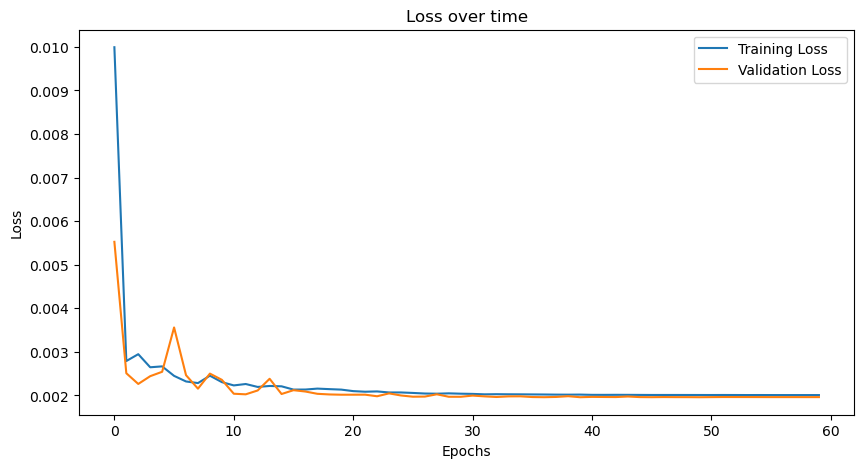

Mean Squared Error on Test Data: 42.711967
Kling-Gupta efficiency on Test Data: 0.9489709087410693


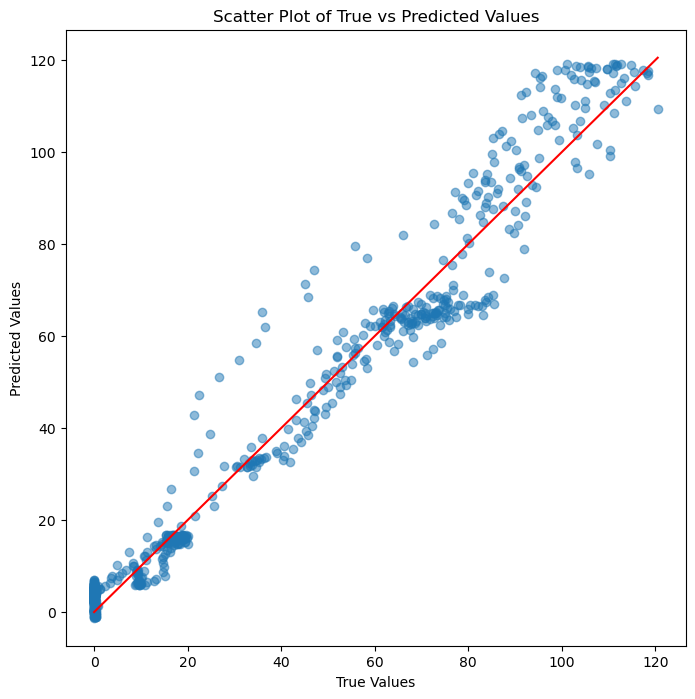

In [137]:
train(['HS','precipitation'], 1, hidden_dims=[70, 50, 30], num_epochs=60, df=df_6, df_test=df_test_6, scaler_y=scaler_y_dict[6])

snow_1

Epoch 1/100, Train Loss: 0.014208617287811868, Val Loss: 0.0025079716145872365
Epoch 2/100, Train Loss: 0.0023650275331486195, Val Loss: 0.002286982020990755
Epoch 3/100, Train Loss: 0.002367584893376019, Val Loss: 0.002815486702472451
Epoch 4/100, Train Loss: 0.002300441951207145, Val Loss: 0.002230933759173642
Epoch 5/100, Train Loss: 0.0022014091464854744, Val Loss: 0.0022015217971956044
Epoch 6/100, Train Loss: 0.0023011117228286843, Val Loss: 0.0022040396014951936
Epoch 7/100, Train Loss: 0.0021752453127340315, Val Loss: 0.002273404271473764
Epoch 8/100, Train Loss: 0.002289310649892739, Val Loss: 0.002141813294814156
Epoch 9/100, Train Loss: 0.002115692270324114, Val Loss: 0.002232847746177836
Epoch 10/100, Train Loss: 0.002309341151307261, Val Loss: 0.002906830872552941
Epoch 11/100, Train Loss: 0.002061039415815677, Val Loss: 0.0020052106667793647
Epoch 12/100, Train Loss: 0.0020412783919885563, Val Loss: 0.0020805408492136765
Epoch 13/100, Train Loss: 0.0020263428784818927, Va

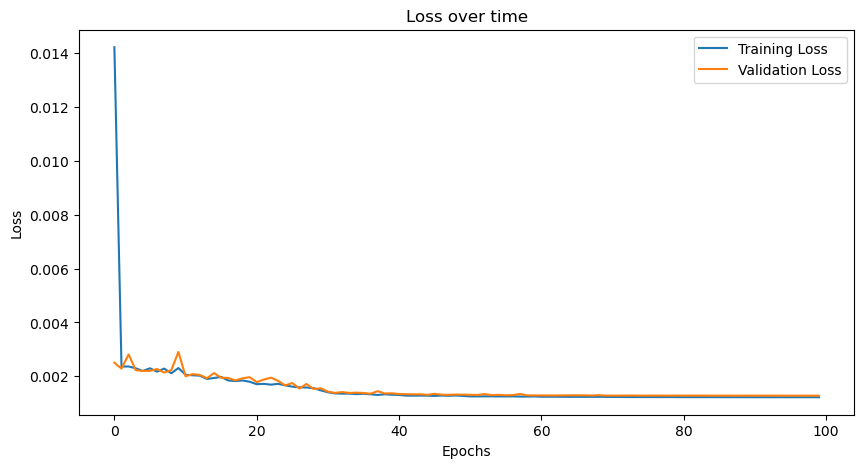

Mean Squared Error on Test Data: 29.236671
Kling-Gupta efficiency on Test Data: 0.9412060437321227


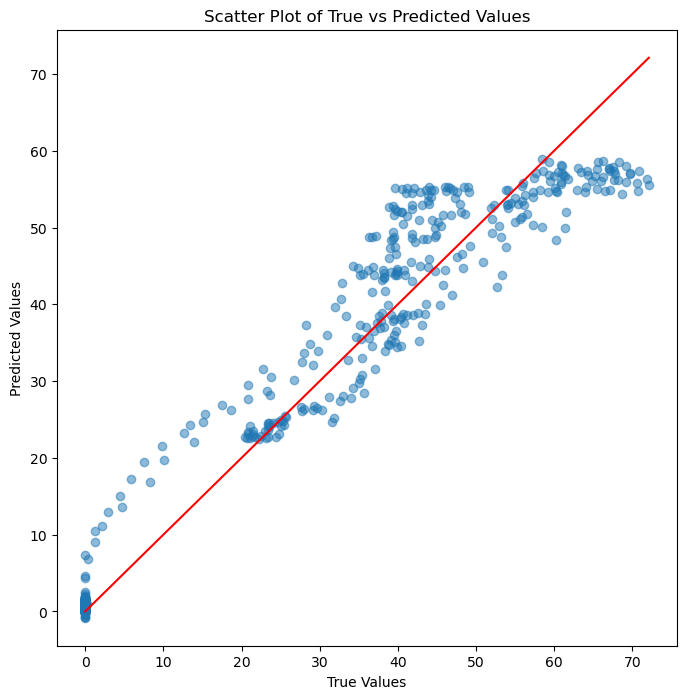

LSTM(
  (lstm1): LSTM(2, 70, batch_first=True)
  (lstm2): LSTM(70, 50, batch_first=True)
  (lstm3): LSTM(50, 30, batch_first=True)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [94]:
train(['HS','precipitation'], 1, hidden_dims=[70, 50, 30], num_epochs=100, df=df_1, df_test=df_test_1, scaler_y=scaler_y)